# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.mean(moment_loss)
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv("sp500_20180101_20181231_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("sp500_20180101_20181231_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats




alpha = 2
beta1 = 0
beta2 = 0
delta0 = 0.55
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1




initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1

return_mean1                           0.954739
return_mean2                           0.865205
return_sd1                             2.839637
return_sd2                             2.726463
return_skew1                           0.884836
return_skew2                           0.884836
return_kurtosis1                      54.285777
return_kurtosis2                     154.154508
return_autocorrelation_ts1_lag1        0.008362
return_autocorrelation_ts1_lag2        0.009658
return_autocorrelation_ts1_lag3        0.007357
return_autocorrelation_ts2_lag1        0.007440
return_autocorrelation_ts2_lag2        0.009687
return_autocorrelation_ts2_lag3        0.008287
return_correlation_ts1_lag_0           0.430792
return_correlation_ts1_lag_1           0.007398
return_correlation_ts1_lag_2           0.008060
return_correlation_ts1_lag_3           0.008873
return_correlation_ts2_lag_1           0.009362
return_correlation_ts2

return_mean1                           0.227540
return_mean2                           0.853613
return_sd1                             2.993916
return_sd2                             2.746808
return_skew1                           0.876446
return_skew2                           0.876446
return_kurtosis1                      54.491165
return_kurtosis2                     153.918407
return_autocorrelation_ts1_lag1        0.009053
return_autocorrelation_ts1_lag2        0.013508
return_autocorrelation_ts1_lag3        0.007586
return_autocorrelation_ts2_lag1        0.008106
return_autocorrelation_ts2_lag2        0.009900
return_autocorrelation_ts2_lag3        0.008125
return_correlation_ts1_lag_0           0.426829
return_correlation_ts1_lag_1           0.007883
return_correlation_ts1_lag_2           0.009765
return_correlation_ts1_lag_3           0.008309
return_correlation_ts2_lag_1           0.009116
return_correlation_ts2_lag_2           0.010601
return_correlation_ts2_lag_3           0

return_mean1                           0.167938
return_mean2                           0.832324
return_sd1                             2.991618
return_sd2                             2.743081
return_skew1                           0.983933
return_skew2                           0.983933
return_kurtosis1                      56.907779
return_kurtosis2                     156.352074
return_autocorrelation_ts1_lag1        0.011013
return_autocorrelation_ts1_lag2        0.012858
return_autocorrelation_ts1_lag3        0.006814
return_autocorrelation_ts2_lag1        0.009106
return_autocorrelation_ts2_lag2        0.008299
return_autocorrelation_ts2_lag3        0.008991
return_correlation_ts1_lag_0           0.425640
return_correlation_ts1_lag_1           0.007915
return_correlation_ts1_lag_2           0.008357
return_correlation_ts1_lag_3           0.008253
return_correlation_ts2_lag_1           0.009815
return_correlation_ts2_lag_2           0.010229
return_correlation_ts2_lag_3           0

return_mean1                           0.187054
return_mean2                           0.876034
return_sd1                             3.001581
return_sd2                             2.740062
return_skew1                           0.956560
return_skew2                           0.956560
return_kurtosis1                      56.353030
return_kurtosis2                     156.173737
return_autocorrelation_ts1_lag1        0.010558
return_autocorrelation_ts1_lag2        0.010639
return_autocorrelation_ts1_lag3        0.006946
return_autocorrelation_ts2_lag1        0.008442
return_autocorrelation_ts2_lag2        0.009034
return_autocorrelation_ts2_lag3        0.008818
return_correlation_ts1_lag_0           0.425582
return_correlation_ts1_lag_1           0.008038
return_correlation_ts1_lag_2           0.007647
return_correlation_ts1_lag_3           0.009170
return_correlation_ts2_lag_1           0.010009
return_correlation_ts2_lag_2           0.008627
return_correlation_ts2_lag_3           0

return_mean1                           2.159422
return_mean2                           0.845182
return_sd1                             6.643026
return_sd2                             2.693227
return_skew1                           0.833731
return_skew2                           0.833731
return_kurtosis1                      51.054067
return_kurtosis2                     152.365704
return_autocorrelation_ts1_lag1        0.152854
return_autocorrelation_ts1_lag2        0.163699
return_autocorrelation_ts1_lag3        0.115466
return_autocorrelation_ts2_lag1        0.008179
return_autocorrelation_ts2_lag2        0.009571
return_autocorrelation_ts2_lag3        0.009051
return_correlation_ts1_lag_0           0.262305
return_correlation_ts1_lag_1           0.009018
return_correlation_ts1_lag_2           0.011483
return_correlation_ts1_lag_3           0.010749
return_correlation_ts2_lag_1           0.010990
return_correlation_ts2_lag_2           0.014914
return_correlation_ts2_lag_3           0

return_mean1                           2.318800
return_mean2                           0.881420
return_sd1                             8.243157
return_sd2                             2.793118
return_skew1                           0.903305
return_skew2                           0.903305
return_kurtosis1                      48.190142
return_kurtosis2                     150.962236
return_autocorrelation_ts1_lag1        0.201391
return_autocorrelation_ts1_lag2        0.211559
return_autocorrelation_ts1_lag3        0.154979
return_autocorrelation_ts2_lag1        0.008184
return_autocorrelation_ts2_lag2        0.009868
return_autocorrelation_ts2_lag3        0.008845
return_correlation_ts1_lag_0           0.222970
return_correlation_ts1_lag_1           0.008469
return_correlation_ts1_lag_2           0.009950
return_correlation_ts1_lag_3           0.009269
return_correlation_ts2_lag_1           0.011879
return_correlation_ts2_lag_2           0.015853
return_correlation_ts2_lag_3           0

return_mean1                           2.340907
return_mean2                           0.837499
return_sd1                             8.452642
return_sd2                             2.754263
return_skew1                           0.976091
return_skew2                           0.976091
return_kurtosis1                      48.811730
return_kurtosis2                     160.088891
return_autocorrelation_ts1_lag1        0.211638
return_autocorrelation_ts1_lag2        0.221650
return_autocorrelation_ts1_lag3        0.162832
return_autocorrelation_ts2_lag1        0.008947
return_autocorrelation_ts2_lag2        0.008918
return_autocorrelation_ts2_lag3        0.009527
return_correlation_ts1_lag_0           0.215326
return_correlation_ts1_lag_1           0.007901
return_correlation_ts1_lag_2           0.009300
return_correlation_ts1_lag_3           0.009131
return_correlation_ts2_lag_1           0.011487
return_correlation_ts2_lag_2           0.014506
return_correlation_ts2_lag_3           0

return_mean1                           2.336893
return_mean2                           0.866610
return_sd1                             8.641962
return_sd2                             2.782755
return_skew1                           0.948700
return_skew2                           0.948700
return_kurtosis1                      47.455831
return_kurtosis2                     153.962950
return_autocorrelation_ts1_lag1        0.211429
return_autocorrelation_ts1_lag2        0.224311
return_autocorrelation_ts1_lag3        0.167425
return_autocorrelation_ts2_lag1        0.008946
return_autocorrelation_ts2_lag2        0.008827
return_autocorrelation_ts2_lag3        0.007566
return_correlation_ts1_lag_0           0.216876
return_correlation_ts1_lag_1           0.008060
return_correlation_ts1_lag_2           0.009770
return_correlation_ts1_lag_3           0.008672
return_correlation_ts2_lag_1           0.012211
return_correlation_ts2_lag_2           0.014951
return_correlation_ts2_lag_3           0

return_mean1                           2.337729
return_mean2                           0.324137
return_sd1                             8.580479
return_sd2                             2.864742
return_skew1                           0.957806
return_skew2                           0.957806
return_kurtosis1                      48.000437
return_kurtosis2                     154.589049
return_autocorrelation_ts1_lag1        0.210909
return_autocorrelation_ts1_lag2        0.222835
return_autocorrelation_ts1_lag3        0.163796
return_autocorrelation_ts2_lag1        0.009931
return_autocorrelation_ts2_lag2        0.009080
return_autocorrelation_ts2_lag3        0.008438
return_correlation_ts1_lag_0           0.235618
return_correlation_ts1_lag_1           0.011549
return_correlation_ts1_lag_2           0.012317
return_correlation_ts1_lag_3           0.009354
return_correlation_ts2_lag_1           0.014992
return_correlation_ts2_lag_2           0.020441
return_correlation_ts2_lag_3           0

return_mean1                           2.334355
return_mean2                           0.739680
return_sd1                             8.630195
return_sd2                             2.788171
return_skew1                           0.954367
return_skew2                           0.954367
return_kurtosis1                      47.977282
return_kurtosis2                     152.805272
return_autocorrelation_ts1_lag1        0.214017
return_autocorrelation_ts1_lag2        0.225655
return_autocorrelation_ts1_lag3        0.166105
return_autocorrelation_ts2_lag1        0.008130
return_autocorrelation_ts2_lag2        0.009096
return_autocorrelation_ts2_lag3        0.009045
return_correlation_ts1_lag_0           0.218767
return_correlation_ts1_lag_1           0.009987
return_correlation_ts1_lag_2           0.011137
return_correlation_ts1_lag_3           0.009366
return_correlation_ts2_lag_1           0.013464
return_correlation_ts2_lag_2           0.015583
return_correlation_ts2_lag_3           0

return_mean1                           2.339977
return_mean2                           0.683830
return_sd1                             8.559313
return_sd2                             2.778480
return_skew1                           0.948910
return_skew2                           0.948910
return_kurtosis1                      47.609513
return_kurtosis2                     153.230066
return_autocorrelation_ts1_lag1        0.211008
return_autocorrelation_ts1_lag2        0.223024
return_autocorrelation_ts1_lag3        0.166135
return_autocorrelation_ts2_lag1        0.007918
return_autocorrelation_ts2_lag2        0.009018
return_autocorrelation_ts2_lag3        0.008999
return_correlation_ts1_lag_0           0.220870
return_correlation_ts1_lag_1           0.008737
return_correlation_ts1_lag_2           0.010664
return_correlation_ts1_lag_3           0.009235
return_correlation_ts2_lag_1           0.011417
return_correlation_ts2_lag_2           0.015575
return_correlation_ts2_lag_3           0

return_mean1                           2.361806
return_mean2                           0.719370
return_sd1                             8.530854
return_sd2                             2.749375
return_skew1                           0.945880
return_skew2                           0.945880
return_kurtosis1                      48.057202
return_kurtosis2                     153.684750
return_autocorrelation_ts1_lag1        0.214041
return_autocorrelation_ts1_lag2        0.221783
return_autocorrelation_ts1_lag3        0.163336
return_autocorrelation_ts2_lag1        0.009242
return_autocorrelation_ts2_lag2        0.009171
return_autocorrelation_ts2_lag3        0.009090
return_correlation_ts1_lag_0           0.218715
return_correlation_ts1_lag_1           0.008502
return_correlation_ts1_lag_2           0.011122
return_correlation_ts1_lag_3           0.010352
return_correlation_ts2_lag_1           0.012028
return_correlation_ts2_lag_2           0.015021
return_correlation_ts2_lag_3           0

return_mean1                           2.343953
return_mean2                           0.689515
return_sd1                             8.463687
return_sd2                             2.757712
return_skew1                           0.912918
return_skew2                           0.912918
return_kurtosis1                      47.915080
return_kurtosis2                     153.234012
return_autocorrelation_ts1_lag1        0.213096
return_autocorrelation_ts1_lag2        0.222410
return_autocorrelation_ts1_lag3        0.162391
return_autocorrelation_ts2_lag1        0.007786
return_autocorrelation_ts2_lag2        0.009321
return_autocorrelation_ts2_lag3        0.008739
return_correlation_ts1_lag_0           0.216177
return_correlation_ts1_lag_1           0.008451
return_correlation_ts1_lag_2           0.010647
return_correlation_ts1_lag_3           0.009056
return_correlation_ts2_lag_1           0.012020
return_correlation_ts2_lag_2           0.015367
return_correlation_ts2_lag_3           0

return_mean1                           2.336697
return_mean2                           0.095411
return_sd1                             8.527140
return_sd2                             2.668004
return_skew1                           0.967966
return_skew2                           0.967966
return_kurtosis1                      47.321221
return_kurtosis2                     153.713648
return_autocorrelation_ts1_lag1        0.213800
return_autocorrelation_ts1_lag2        0.221881
return_autocorrelation_ts1_lag3        0.166411
return_autocorrelation_ts2_lag1        0.007889
return_autocorrelation_ts2_lag2        0.009656
return_autocorrelation_ts2_lag3        0.008404
return_correlation_ts1_lag_0           0.193919
return_correlation_ts1_lag_1           0.005873
return_correlation_ts1_lag_2           0.009436
return_correlation_ts1_lag_3           0.007117
return_correlation_ts2_lag_1           0.008591
return_correlation_ts2_lag_2           0.010949
return_correlation_ts2_lag_3           0

return_mean1                           2.343482
return_mean2                           0.101943
return_sd1                             8.588912
return_sd2                             2.697207
return_skew1                           0.965977
return_skew2                           0.965977
return_kurtosis1                      47.138649
return_kurtosis2                     151.108972
return_autocorrelation_ts1_lag1        0.213249
return_autocorrelation_ts1_lag2        0.230781
return_autocorrelation_ts1_lag3        0.166524
return_autocorrelation_ts2_lag1        0.007719
return_autocorrelation_ts2_lag2        0.009631
return_autocorrelation_ts2_lag3        0.009354
return_correlation_ts1_lag_0           0.194460
return_correlation_ts1_lag_1           0.006499
return_correlation_ts1_lag_2           0.008944
return_correlation_ts1_lag_3           0.009648
return_correlation_ts2_lag_1           0.007906
return_correlation_ts2_lag_2           0.011915
return_correlation_ts2_lag_3           0

return_mean1                           2.329576
return_mean2                           0.092996
return_sd1                             6.801209
return_sd2                             2.662895
return_skew1                           1.065547
return_skew2                           1.065547
return_kurtosis1                      46.053284
return_kurtosis2                     153.186075
return_autocorrelation_ts1_lag1        0.280311
return_autocorrelation_ts1_lag2        0.291956
return_autocorrelation_ts1_lag3        0.223969
return_autocorrelation_ts2_lag1        0.007990
return_autocorrelation_ts2_lag2        0.008574
return_autocorrelation_ts2_lag3        0.009128
return_correlation_ts1_lag_0           0.148274
return_correlation_ts1_lag_1           0.006448
return_correlation_ts1_lag_2           0.007400
return_correlation_ts1_lag_3           0.009473
return_correlation_ts2_lag_1           0.008539
return_correlation_ts2_lag_2           0.011511
return_correlation_ts2_lag_3           0

return_mean1                           2.333803
return_mean2                           0.091108
return_sd1                             6.031758
return_sd2                             2.659432
return_skew1                           1.166940
return_skew2                           1.166940
return_kurtosis1                      44.867858
return_kurtosis2                     153.022161
return_autocorrelation_ts1_lag1        0.321011
return_autocorrelation_ts1_lag2        0.338733
return_autocorrelation_ts1_lag3        0.263815
return_autocorrelation_ts2_lag1        0.008173
return_autocorrelation_ts2_lag2        0.009235
return_autocorrelation_ts2_lag3        0.009423
return_correlation_ts1_lag_0           0.119966
return_correlation_ts1_lag_1           0.007833
return_correlation_ts1_lag_2           0.007800
return_correlation_ts1_lag_3           0.008008
return_correlation_ts2_lag_1           0.009999
return_correlation_ts2_lag_2           0.011240
return_correlation_ts2_lag_3           0

return_mean1                           2.343545
return_mean2                           0.091230
return_sd1                             6.102363
return_sd2                             2.648373
return_skew1                           1.151493
return_skew2                           1.151493
return_kurtosis1                      45.025293
return_kurtosis2                     153.496121
return_autocorrelation_ts1_lag1        0.319694
return_autocorrelation_ts1_lag2        0.334998
return_autocorrelation_ts1_lag3        0.259784
return_autocorrelation_ts2_lag1        0.008065
return_autocorrelation_ts2_lag2        0.008778
return_autocorrelation_ts2_lag3        0.008610
return_correlation_ts1_lag_0           0.123681
return_correlation_ts1_lag_1           0.007106
return_correlation_ts1_lag_2           0.009442
return_correlation_ts1_lag_3           0.008167
return_correlation_ts2_lag_1           0.009546
return_correlation_ts2_lag_2           0.010656
return_correlation_ts2_lag_3           0

return_mean1                           2.329675
return_mean2                           0.087322
return_sd1                             3.613282
return_sd2                             2.668943
return_skew1                           2.177161
return_skew2                           2.177161
return_kurtosis1                      39.137948
return_kurtosis2                     154.271997
return_autocorrelation_ts1_lag1        0.609377
return_autocorrelation_ts1_lag2        0.632954
return_autocorrelation_ts1_lag3        0.532839
return_autocorrelation_ts2_lag1        0.009046
return_autocorrelation_ts2_lag2        0.009119
return_autocorrelation_ts2_lag3        0.008395
return_correlation_ts1_lag_0           0.052180
return_correlation_ts1_lag_1           0.008162
return_correlation_ts1_lag_2           0.008637
return_correlation_ts1_lag_3           0.007627
return_correlation_ts2_lag_1           0.008756
return_correlation_ts2_lag_2           0.011515
return_correlation_ts2_lag_3           0

return_mean1                           2.341363
return_mean2                           0.108096
return_sd1                             3.312809
return_sd2                             2.692570
return_skew1                           2.488557
return_skew2                           2.488557
return_kurtosis1                      36.959446
return_kurtosis2                     154.015733
return_autocorrelation_ts1_lag1        0.683322
return_autocorrelation_ts1_lag2        0.710102
return_autocorrelation_ts1_lag3        0.605265
return_autocorrelation_ts2_lag1        0.007710
return_autocorrelation_ts2_lag2        0.009534
return_autocorrelation_ts2_lag3        0.007596
return_correlation_ts1_lag_0           0.037613
return_correlation_ts1_lag_1           0.008664
return_correlation_ts1_lag_2           0.009580
return_correlation_ts1_lag_3           0.009353
return_correlation_ts2_lag_1           0.010048
return_correlation_ts2_lag_2           0.012935
return_correlation_ts2_lag_3           0

return_mean1                           2.335593
return_mean2                           0.094586
return_sd1                             3.325454
return_sd2                             2.699889
return_skew1                           2.469202
return_skew2                           2.469202
return_kurtosis1                      37.375844
return_kurtosis2                     153.126722
return_autocorrelation_ts1_lag1        0.677813
return_autocorrelation_ts1_lag2        0.701919
return_autocorrelation_ts1_lag3        0.598904
return_autocorrelation_ts2_lag1        0.008185
return_autocorrelation_ts2_lag2        0.009255
return_autocorrelation_ts2_lag3        0.008483
return_correlation_ts1_lag_0           0.036683
return_correlation_ts1_lag_1           0.008225
return_correlation_ts1_lag_2           0.008501
return_correlation_ts1_lag_3           0.008469
return_correlation_ts2_lag_1           0.010618
return_correlation_ts2_lag_2           0.011717
return_correlation_ts2_lag_3           0

return_mean1                           2.336310
return_mean2                           0.095295
return_sd1                             3.328117
return_sd2                             2.623339
return_skew1                           2.521859
return_skew2                           2.521859
return_kurtosis1                      35.669288
return_kurtosis2                     149.239501
return_autocorrelation_ts1_lag1        0.681371
return_autocorrelation_ts1_lag2        0.706085
return_autocorrelation_ts1_lag3        0.600262
return_autocorrelation_ts2_lag1        0.008814
return_autocorrelation_ts2_lag2        0.010214
return_autocorrelation_ts2_lag3        0.009690
return_correlation_ts1_lag_0           0.040234
return_correlation_ts1_lag_1           0.008071
return_correlation_ts1_lag_2           0.009858
return_correlation_ts1_lag_3           0.009433
return_correlation_ts2_lag_1           0.011412
return_correlation_ts2_lag_2           0.013140
return_correlation_ts2_lag_3           0

return_mean1                           2.333915
return_mean2                           0.094397
return_sd1                             3.334364
return_sd2                             2.357594
return_skew1                           2.555753
return_skew2                           2.555753
return_kurtosis1                      38.243088
return_kurtosis2                     152.594856
return_autocorrelation_ts1_lag1        0.679370
return_autocorrelation_ts1_lag2        0.704612
return_autocorrelation_ts1_lag3        0.600519
return_autocorrelation_ts2_lag1        0.008715
return_autocorrelation_ts2_lag2        0.009193
return_autocorrelation_ts2_lag3        0.008323
return_correlation_ts1_lag_0           0.040981
return_correlation_ts1_lag_1           0.009103
return_correlation_ts1_lag_2           0.009384
return_correlation_ts1_lag_3           0.008770
return_correlation_ts2_lag_1           0.011563
return_correlation_ts2_lag_2           0.012366
return_correlation_ts2_lag_3           0

return_mean1                           2.334281
return_mean2                           0.106710
return_sd1                             3.332251
return_sd2                             2.930551
return_skew1                           2.633902
return_skew2                           2.633902
return_kurtosis1                      48.338810
return_kurtosis2                     154.688261
return_autocorrelation_ts1_lag1        0.675852
return_autocorrelation_ts1_lag2        0.702260
return_autocorrelation_ts1_lag3        0.596768
return_autocorrelation_ts2_lag1        0.007176
return_autocorrelation_ts2_lag2        0.008446
return_autocorrelation_ts2_lag3        0.008564
return_correlation_ts1_lag_0           0.039040
return_correlation_ts1_lag_1           0.009091
return_correlation_ts1_lag_2           0.010948
return_correlation_ts1_lag_3           0.009727
return_correlation_ts2_lag_1           0.010477
return_correlation_ts2_lag_2           0.013536
return_correlation_ts2_lag_3           0

return_mean1                           2.324449
return_mean2                           0.078748
return_sd1                             3.342089
return_sd2                             3.002509
return_skew1                           2.464080
return_skew2                           2.464080
return_kurtosis1                      36.503710
return_kurtosis2                     153.205110
return_autocorrelation_ts1_lag1        0.675616
return_autocorrelation_ts1_lag2        0.700471
return_autocorrelation_ts1_lag3        0.596119
return_autocorrelation_ts2_lag1        0.008021
return_autocorrelation_ts2_lag2        0.008766
return_autocorrelation_ts2_lag3        0.008786
return_correlation_ts1_lag_0           0.040062
return_correlation_ts1_lag_1           0.006959
return_correlation_ts1_lag_2           0.008529
return_correlation_ts1_lag_3           0.008355
return_correlation_ts2_lag_1           0.009515
return_correlation_ts2_lag_2           0.011711
return_correlation_ts2_lag_3           0

return_mean1                           2.336072
return_mean2                           0.096348
return_sd1                             3.333592
return_sd2                             2.937406
return_skew1                           2.506723
return_skew2                           2.506723
return_kurtosis1                      37.667402
return_kurtosis2                     154.520916
return_autocorrelation_ts1_lag1        0.678197
return_autocorrelation_ts1_lag2        0.702281
return_autocorrelation_ts1_lag3        0.598089
return_autocorrelation_ts2_lag1        0.008565
return_autocorrelation_ts2_lag2        0.009266
return_autocorrelation_ts2_lag3        0.007623
return_correlation_ts1_lag_0           0.041363
return_correlation_ts1_lag_1           0.007641
return_correlation_ts1_lag_2           0.008981
return_correlation_ts1_lag_3           0.009903
return_correlation_ts2_lag_1           0.009906
return_correlation_ts2_lag_2           0.012502
return_correlation_ts2_lag_3           0

return_mean1                           2.333103
return_mean2                           0.083500
return_sd1                             3.307220
return_sd2                             0.880557
return_skew1                           2.524559
return_skew2                           2.524559
return_kurtosis1                      37.394930
return_kurtosis2                     149.130372
return_autocorrelation_ts1_lag1        0.680067
return_autocorrelation_ts1_lag2        0.706814
return_autocorrelation_ts1_lag3        0.600052
return_autocorrelation_ts2_lag1        0.007834
return_autocorrelation_ts2_lag2        0.009944
return_autocorrelation_ts2_lag3        0.008612
return_correlation_ts1_lag_0           0.044582
return_correlation_ts1_lag_1           0.007879
return_correlation_ts1_lag_2           0.010023
return_correlation_ts1_lag_3           0.009337
return_correlation_ts2_lag_1           0.011205
return_correlation_ts2_lag_2           0.013557
return_correlation_ts2_lag_3           0

return_mean1                           2.338083
return_mean2                           0.086756
return_sd1                             3.354910
return_sd2                             0.860985
return_skew1                           2.524931
return_skew2                           2.524931
return_kurtosis1                      37.616757
return_kurtosis2                     153.738031
return_autocorrelation_ts1_lag1        0.675634
return_autocorrelation_ts1_lag2        0.702314
return_autocorrelation_ts1_lag3        0.597107
return_autocorrelation_ts2_lag1        0.008909
return_autocorrelation_ts2_lag2        0.008714
return_autocorrelation_ts2_lag3        0.009337
return_correlation_ts1_lag_0           0.045686
return_correlation_ts1_lag_1           0.009067
return_correlation_ts1_lag_2           0.011050
return_correlation_ts1_lag_3           0.010007
return_correlation_ts2_lag_1           0.010993
return_correlation_ts2_lag_2           0.014970
return_correlation_ts2_lag_3           0

return_mean1                           2.334016
return_mean2                           0.083395
return_sd1                             3.340280
return_sd2                             0.877727
return_skew1                           2.519112
return_skew2                           2.519112
return_kurtosis1                      37.028779
return_kurtosis2                     150.973401
return_autocorrelation_ts1_lag1        0.678532
return_autocorrelation_ts1_lag2        0.706213
return_autocorrelation_ts1_lag3        0.604008
return_autocorrelation_ts2_lag1        0.008031
return_autocorrelation_ts2_lag2        0.010002
return_autocorrelation_ts2_lag3        0.007879
return_correlation_ts1_lag_0           0.045670
return_correlation_ts1_lag_1           0.008757
return_correlation_ts1_lag_2           0.010738
return_correlation_ts1_lag_3           0.008985
return_correlation_ts2_lag_1           0.010846
return_correlation_ts2_lag_2           0.014855
return_correlation_ts2_lag_3           0

return_mean1                            2.345353
return_mean2                            0.081315
return_sd1                             12.641695
return_sd2                              0.869022
return_skew1                           12.573885
return_skew2                           12.573885
return_kurtosis1                     1737.024064
return_kurtosis2                      155.440725
return_autocorrelation_ts1_lag1         0.285119
return_autocorrelation_ts1_lag2         0.293812
return_autocorrelation_ts1_lag3         0.231430
return_autocorrelation_ts2_lag1         0.007701
return_autocorrelation_ts2_lag2         0.008620
return_autocorrelation_ts2_lag3         0.008609
return_correlation_ts1_lag_0            0.036065
return_correlation_ts1_lag_1            0.007431
return_correlation_ts1_lag_2            0.009954
return_correlation_ts1_lag_3            0.008926
return_correlation_ts2_lag_1            0.008961
return_correlation_ts2_lag_2            0.012018
return_correlation_t

return_mean1                           2.343029
return_mean2                           0.093143
return_sd1                             3.383161
return_sd2                             0.926262
return_skew1                           2.536784
return_skew2                           2.536784
return_kurtosis1                      41.413208
return_kurtosis2                     170.471641
return_autocorrelation_ts1_lag1        0.671952
return_autocorrelation_ts1_lag2        0.693262
return_autocorrelation_ts1_lag3        0.589800
return_autocorrelation_ts2_lag1        0.008514
return_autocorrelation_ts2_lag2        0.008264
return_autocorrelation_ts2_lag3        0.009006
return_correlation_ts1_lag_0           0.045889
return_correlation_ts1_lag_1           0.008206
return_correlation_ts1_lag_2           0.010501
return_correlation_ts1_lag_3           0.008103
return_correlation_ts2_lag_1           0.011455
return_correlation_ts2_lag_2           0.013445
return_correlation_ts2_lag_3           0

return_mean1                           2.337567
return_mean2                           0.084024
return_sd1                             3.317539
return_sd2                             0.896361
return_skew1                           2.491397
return_skew2                           2.491397
return_kurtosis1                      37.089206
return_kurtosis2                     153.032039
return_autocorrelation_ts1_lag1        0.673213
return_autocorrelation_ts1_lag2        0.699115
return_autocorrelation_ts1_lag3        0.592786
return_autocorrelation_ts2_lag1        0.007135
return_autocorrelation_ts2_lag2        0.009863
return_autocorrelation_ts2_lag3        0.010070
return_correlation_ts1_lag_0           0.045041
return_correlation_ts1_lag_1           0.007173
return_correlation_ts1_lag_2           0.010587
return_correlation_ts1_lag_3           0.009500
return_correlation_ts2_lag_1           0.008762
return_correlation_ts2_lag_2           0.012582
return_correlation_ts2_lag_3           0

return_mean1                           2.331709
return_mean2                           0.085965
return_sd1                             3.374636
return_sd2                             0.889095
return_skew1                           2.519265
return_skew2                           2.519265
return_kurtosis1                      40.923451
return_kurtosis2                     153.159693
return_autocorrelation_ts1_lag1        0.674560
return_autocorrelation_ts1_lag2        0.697612
return_autocorrelation_ts1_lag3        0.594256
return_autocorrelation_ts2_lag1        0.008193
return_autocorrelation_ts2_lag2        0.007322
return_autocorrelation_ts2_lag3        0.008883
return_correlation_ts1_lag_0           0.045898
return_correlation_ts1_lag_1           0.009679
return_correlation_ts1_lag_2           0.011431
return_correlation_ts1_lag_3           0.008623
return_correlation_ts2_lag_1           0.012864
return_correlation_ts2_lag_2           0.014664
return_correlation_ts2_lag_3           0

return_mean1                           2.336905
return_mean2                           0.079899
return_sd1                             3.338804
return_sd2                             0.880703
return_skew1                           2.535259
return_skew2                           2.535259
return_kurtosis1                      39.092639
return_kurtosis2                     160.641833
return_autocorrelation_ts1_lag1        0.674307
return_autocorrelation_ts1_lag2        0.699534
return_autocorrelation_ts1_lag3        0.595983
return_autocorrelation_ts2_lag1        0.007085
return_autocorrelation_ts2_lag2        0.009215
return_autocorrelation_ts2_lag3        0.007810
return_correlation_ts1_lag_0           0.047026
return_correlation_ts1_lag_1           0.008324
return_correlation_ts1_lag_2           0.010729
return_correlation_ts1_lag_3           0.009790
return_correlation_ts2_lag_1           0.010896
return_correlation_ts2_lag_2           0.013927
return_correlation_ts2_lag_3           0

return_mean1                            2.335846
return_mean2                            0.071896
return_sd1                             11.980545
return_sd2                              0.867702
return_skew1                           12.851379
return_skew2                           12.851379
return_kurtosis1                     1753.159915
return_kurtosis2                      155.220162
return_autocorrelation_ts1_lag1         0.268021
return_autocorrelation_ts1_lag2         0.285589
return_autocorrelation_ts1_lag3         0.223112
return_autocorrelation_ts2_lag1         0.007746
return_autocorrelation_ts2_lag2         0.010122
return_autocorrelation_ts2_lag3         0.008357
return_correlation_ts1_lag_0            0.037049
return_correlation_ts1_lag_1            0.007614
return_correlation_ts1_lag_2            0.010639
return_correlation_ts1_lag_3            0.009414
return_correlation_ts2_lag_1            0.010144
return_correlation_ts2_lag_2            0.012080
return_correlation_t

return_mean1                           2.334394
return_mean2                           0.086809
return_sd1                             3.312477
return_sd2                             0.866451
return_skew1                           2.489470
return_skew2                           2.489470
return_kurtosis1                      37.016958
return_kurtosis2                     156.149326
return_autocorrelation_ts1_lag1        0.687947
return_autocorrelation_ts1_lag2        0.710964
return_autocorrelation_ts1_lag3        0.606033
return_autocorrelation_ts2_lag1        0.007617
return_autocorrelation_ts2_lag2        0.010179
return_autocorrelation_ts2_lag3        0.008380
return_correlation_ts1_lag_0           0.045093
return_correlation_ts1_lag_1           0.008010
return_correlation_ts1_lag_2           0.009698
return_correlation_ts1_lag_3           0.009186
return_correlation_ts2_lag_1           0.011046
return_correlation_ts2_lag_2           0.013693
return_correlation_ts2_lag_3           0

return_mean1                           2.334576
return_mean2                           0.081617
return_sd1                             3.299334
return_sd2                             0.885354
return_skew1                           2.526826
return_skew2                           2.526826
return_kurtosis1                      36.022700
return_kurtosis2                     152.994869
return_autocorrelation_ts1_lag1        0.686228
return_autocorrelation_ts1_lag2        0.714176
return_autocorrelation_ts1_lag3        0.606878
return_autocorrelation_ts2_lag1        0.007451
return_autocorrelation_ts2_lag2        0.009769
return_autocorrelation_ts2_lag3        0.008228
return_correlation_ts1_lag_0           0.046541
return_correlation_ts1_lag_1           0.009000
return_correlation_ts1_lag_2           0.012425
return_correlation_ts1_lag_3           0.009781
return_correlation_ts2_lag_1           0.012284
return_correlation_ts2_lag_2           0.015602
return_correlation_ts2_lag_3           0

return_mean1                           2.328258
return_mean2                           0.073163
return_sd1                             3.281367
return_sd2                             0.852223
return_skew1                           2.553736
return_skew2                           2.553736
return_kurtosis1                      37.212855
return_kurtosis2                     153.287497
return_autocorrelation_ts1_lag1        0.691563
return_autocorrelation_ts1_lag2        0.716072
return_autocorrelation_ts1_lag3        0.611952
return_autocorrelation_ts2_lag1        0.008576
return_autocorrelation_ts2_lag2        0.008566
return_autocorrelation_ts2_lag3        0.009212
return_correlation_ts1_lag_0           0.044857
return_correlation_ts1_lag_1           0.009267
return_correlation_ts1_lag_2           0.010167
return_correlation_ts1_lag_3           0.009748
return_correlation_ts2_lag_1           0.011068
return_correlation_ts2_lag_2           0.014358
return_correlation_ts2_lag_3           0

return_mean1                           2.336517
return_mean2                           0.085462
return_sd1                             3.303175
return_sd2                             0.893266
return_skew1                           2.522617
return_skew2                           2.522617
return_kurtosis1                      36.768570
return_kurtosis2                     152.361975
return_autocorrelation_ts1_lag1        0.690745
return_autocorrelation_ts1_lag2        0.713560
return_autocorrelation_ts1_lag3        0.608363
return_autocorrelation_ts2_lag1        0.007561
return_autocorrelation_ts2_lag2        0.010424
return_autocorrelation_ts2_lag3        0.009695
return_correlation_ts1_lag_0           0.045888
return_correlation_ts1_lag_1           0.009397
return_correlation_ts1_lag_2           0.009953
return_correlation_ts1_lag_3           0.008650
return_correlation_ts2_lag_1           0.010470
return_correlation_ts2_lag_2           0.014532
return_correlation_ts2_lag_3           0

return_mean1                           2.330500
return_mean2                           0.086741
return_sd1                             3.291742
return_sd2                             1.902656
return_skew1                           2.547039
return_skew2                           2.547039
return_kurtosis1                      37.065509
return_kurtosis2                     558.562256
return_autocorrelation_ts1_lag1        0.689785
return_autocorrelation_ts1_lag2        0.716781
return_autocorrelation_ts1_lag3        0.610292
return_autocorrelation_ts2_lag1        0.007786
return_autocorrelation_ts2_lag2        0.008714
return_autocorrelation_ts2_lag3        0.008152
return_correlation_ts1_lag_0           0.040629
return_correlation_ts1_lag_1           0.008509
return_correlation_ts1_lag_2           0.009499
return_correlation_ts1_lag_3           0.008010
return_correlation_ts2_lag_1           0.009326
return_correlation_ts2_lag_2           0.014332
return_correlation_ts2_lag_3           0

return_mean1                           2.330991
return_mean2                           0.080892
return_sd1                             3.298708
return_sd2                             0.910581
return_skew1                           2.521805
return_skew2                           2.521805
return_kurtosis1                      36.857226
return_kurtosis2                     153.690704
return_autocorrelation_ts1_lag1        0.686245
return_autocorrelation_ts1_lag2        0.715280
return_autocorrelation_ts1_lag3        0.607839
return_autocorrelation_ts2_lag1        0.008334
return_autocorrelation_ts2_lag2        0.009409
return_autocorrelation_ts2_lag3        0.008100
return_correlation_ts1_lag_0           0.044679
return_correlation_ts1_lag_1           0.008946
return_correlation_ts1_lag_2           0.009744
return_correlation_ts1_lag_3           0.008261
return_correlation_ts2_lag_1           0.009518
return_correlation_ts2_lag_2           0.014731
return_correlation_ts2_lag_3           0

return_mean1                           2.334236
return_mean2                           0.074863
return_sd1                             3.291997
return_sd2                             0.872588
return_skew1                           2.537639
return_skew2                           2.537639
return_kurtosis1                      37.548727
return_kurtosis2                     154.431860
return_autocorrelation_ts1_lag1        0.686913
return_autocorrelation_ts1_lag2        0.713838
return_autocorrelation_ts1_lag3        0.610927
return_autocorrelation_ts2_lag1        0.009101
return_autocorrelation_ts2_lag2        0.008801
return_autocorrelation_ts2_lag3        0.008139
return_correlation_ts1_lag_0           0.045710
return_correlation_ts1_lag_1           0.008633
return_correlation_ts1_lag_2           0.010591
return_correlation_ts1_lag_3           0.009690
return_correlation_ts2_lag_1           0.011014
return_correlation_ts2_lag_2           0.013619
return_correlation_ts2_lag_3           0

return_mean1                           2.325784
return_mean2                           0.069594
return_sd1                             3.277484
return_sd2                             0.848551
return_skew1                           2.576378
return_skew2                           2.576378
return_kurtosis1                      37.339154
return_kurtosis2                     152.511727
return_autocorrelation_ts1_lag1        0.691198
return_autocorrelation_ts1_lag2        0.718081
return_autocorrelation_ts1_lag3        0.611762
return_autocorrelation_ts2_lag1        0.007096
return_autocorrelation_ts2_lag2        0.008935
return_autocorrelation_ts2_lag3        0.008108
return_correlation_ts1_lag_0           0.043447
return_correlation_ts1_lag_1           0.009373
return_correlation_ts1_lag_2           0.011508
return_correlation_ts1_lag_3           0.009199
return_correlation_ts2_lag_1           0.010540
return_correlation_ts2_lag_2           0.015741
return_correlation_ts2_lag_3           0

return_mean1                           2.345756
return_mean2                           0.085085
return_sd1                             3.309202
return_sd2                             0.889293
return_skew1                           2.591810
return_skew2                           2.591810
return_kurtosis1                      37.412238
return_kurtosis2                     150.268865
return_autocorrelation_ts1_lag1        0.690284
return_autocorrelation_ts1_lag2        0.716772
return_autocorrelation_ts1_lag3        0.612239
return_autocorrelation_ts2_lag1        0.007696
return_autocorrelation_ts2_lag2        0.009119
return_autocorrelation_ts2_lag3        0.008614
return_correlation_ts1_lag_0           0.047738
return_correlation_ts1_lag_1           0.008766
return_correlation_ts1_lag_2           0.011703
return_correlation_ts1_lag_3           0.009255
return_correlation_ts2_lag_1           0.010809
return_correlation_ts2_lag_2           0.015926
return_correlation_ts2_lag_3           0

return_mean1                            2.331569
return_mean2                            0.116925
return_sd1                              3.287275
return_sd2                              8.186819
return_skew1                            2.544694
return_skew2                            2.544694
return_kurtosis1                       36.895406
return_kurtosis2                     2956.378156
return_autocorrelation_ts1_lag1         0.690726
return_autocorrelation_ts1_lag2         0.716726
return_autocorrelation_ts1_lag3         0.611508
return_autocorrelation_ts2_lag1         0.007834
return_autocorrelation_ts2_lag2         0.008630
return_autocorrelation_ts2_lag3         0.008066
return_correlation_ts1_lag_0            0.035608
return_correlation_ts1_lag_1            0.007225
return_correlation_ts1_lag_2            0.010007
return_correlation_ts1_lag_3            0.007778
return_correlation_ts2_lag_1            0.008925
return_correlation_ts2_lag_2            0.012196
return_correlation_t

return_mean1                           2.339636
return_mean2                           0.078987
return_sd1                             3.264181
return_sd2                             0.897901
return_skew1                           2.535133
return_skew2                           2.535133
return_kurtosis1                      37.472273
return_kurtosis2                     149.836242
return_autocorrelation_ts1_lag1        0.686633
return_autocorrelation_ts1_lag2        0.714525
return_autocorrelation_ts1_lag3        0.609344
return_autocorrelation_ts2_lag1        0.008046
return_autocorrelation_ts2_lag2        0.009306
return_autocorrelation_ts2_lag3        0.008638
return_correlation_ts1_lag_0           0.041078
return_correlation_ts1_lag_1           0.007627
return_correlation_ts1_lag_2           0.010640
return_correlation_ts1_lag_3           0.008897
return_correlation_ts2_lag_1           0.010006
return_correlation_ts2_lag_2           0.013325
return_correlation_ts2_lag_3           0

return_mean1                           2.331394
return_mean2                           0.081324
return_sd1                             3.292104
return_sd2                             0.869276
return_skew1                           2.562662
return_skew2                           2.562662
return_kurtosis1                      37.463656
return_kurtosis2                     151.283121
return_autocorrelation_ts1_lag1        0.687751
return_autocorrelation_ts1_lag2        0.713055
return_autocorrelation_ts1_lag3        0.609371
return_autocorrelation_ts2_lag1        0.007215
return_autocorrelation_ts2_lag2        0.008303
return_autocorrelation_ts2_lag3        0.007863
return_correlation_ts1_lag_0           0.045301
return_correlation_ts1_lag_1           0.008022
return_correlation_ts1_lag_2           0.009872
return_correlation_ts1_lag_3           0.008623
return_correlation_ts2_lag_1           0.011041
return_correlation_ts2_lag_2           0.013924
return_correlation_ts2_lag_3           0

return_mean1                           2.333879
return_mean2                           0.082374
return_sd1                             3.311894
return_sd2                             0.894325
return_skew1                           2.572480
return_skew2                           2.572480
return_kurtosis1                      37.142133
return_kurtosis2                     155.515282
return_autocorrelation_ts1_lag1        0.688937
return_autocorrelation_ts1_lag2        0.714274
return_autocorrelation_ts1_lag3        0.608008
return_autocorrelation_ts2_lag1        0.009144
return_autocorrelation_ts2_lag2        0.008811
return_autocorrelation_ts2_lag3        0.008959
return_correlation_ts1_lag_0           0.046481
return_correlation_ts1_lag_1           0.010514
return_correlation_ts1_lag_2           0.011015
return_correlation_ts1_lag_3           0.009995
return_correlation_ts2_lag_1           0.011521
return_correlation_ts2_lag_2           0.014347
return_correlation_ts2_lag_3           0

return_mean1                           2.333872
return_mean2                           0.081145
return_sd1                             3.305201
return_sd2                             0.908365
return_skew1                           2.541087
return_skew2                           2.541087
return_kurtosis1                      37.548189
return_kurtosis2                     174.865409
return_autocorrelation_ts1_lag1        0.685777
return_autocorrelation_ts1_lag2        0.711068
return_autocorrelation_ts1_lag3        0.606005
return_autocorrelation_ts2_lag1        0.007199
return_autocorrelation_ts2_lag2        0.008364
return_autocorrelation_ts2_lag3        0.008093
return_correlation_ts1_lag_0           0.045151
return_correlation_ts1_lag_1           0.008480
return_correlation_ts1_lag_2           0.010228
return_correlation_ts1_lag_3           0.008964
return_correlation_ts2_lag_1           0.011044
return_correlation_ts2_lag_2           0.013767
return_correlation_ts2_lag_3           0

return_mean1                           2.331071
return_mean2                           0.076614
return_sd1                             3.272411
return_sd2                             0.878587
return_skew1                           2.550337
return_skew2                           2.550337
return_kurtosis1                      38.067274
return_kurtosis2                     155.373216
return_autocorrelation_ts1_lag1        0.690832
return_autocorrelation_ts1_lag2        0.715550
return_autocorrelation_ts1_lag3        0.607895
return_autocorrelation_ts2_lag1        0.008435
return_autocorrelation_ts2_lag2        0.008871
return_autocorrelation_ts2_lag3        0.008101
return_correlation_ts1_lag_0           0.044153
return_correlation_ts1_lag_1           0.009697
return_correlation_ts1_lag_2           0.010642
return_correlation_ts1_lag_3           0.008511
return_correlation_ts2_lag_1           0.011704
return_correlation_ts2_lag_2           0.014474
return_correlation_ts2_lag_3           0

return_mean1                           2.012026
return_mean2                           0.082144
return_sd1                             3.373472
return_sd2                             0.884387
return_skew1                           2.557331
return_skew2                           2.557331
return_kurtosis1                      36.767923
return_kurtosis2                     151.656611
return_autocorrelation_ts1_lag1        0.694816
return_autocorrelation_ts1_lag2        0.718991
return_autocorrelation_ts1_lag3        0.612269
return_autocorrelation_ts2_lag1        0.007940
return_autocorrelation_ts2_lag2        0.010040
return_autocorrelation_ts2_lag3        0.008842
return_correlation_ts1_lag_0           0.044461
return_correlation_ts1_lag_1           0.008607
return_correlation_ts1_lag_2           0.010150
return_correlation_ts1_lag_3           0.008034
return_correlation_ts2_lag_1           0.011433
return_correlation_ts2_lag_2           0.014042
return_correlation_ts2_lag_3           0

return_mean1                           2.175231
return_mean2                           0.085293
return_sd1                             3.332035
return_sd2                             0.879703
return_skew1                           2.573663
return_skew2                           2.573663
return_kurtosis1                      37.143888
return_kurtosis2                     155.577301
return_autocorrelation_ts1_lag1        0.686758
return_autocorrelation_ts1_lag2        0.714705
return_autocorrelation_ts1_lag3        0.610894
return_autocorrelation_ts2_lag1        0.009554
return_autocorrelation_ts2_lag2        0.009125
return_autocorrelation_ts2_lag3        0.007615
return_correlation_ts1_lag_0           0.045061
return_correlation_ts1_lag_1           0.008944
return_correlation_ts1_lag_2           0.010910
return_correlation_ts1_lag_3           0.009547
return_correlation_ts2_lag_1           0.010541
return_correlation_ts2_lag_2           0.014947
return_correlation_ts2_lag_3           0

return_mean1                           2.169769
return_mean2                           0.079127
return_sd1                             3.344014
return_sd2                             0.895372
return_skew1                           2.648316
return_skew2                           2.648316
return_kurtosis1                      52.067095
return_kurtosis2                     191.903942
return_autocorrelation_ts1_lag1        0.685481
return_autocorrelation_ts1_lag2        0.711916
return_autocorrelation_ts1_lag3        0.608615
return_autocorrelation_ts2_lag1        0.006697
return_autocorrelation_ts2_lag2        0.008535
return_autocorrelation_ts2_lag3        0.008433
return_correlation_ts1_lag_0           0.044772
return_correlation_ts1_lag_1           0.009004
return_correlation_ts1_lag_2           0.011409
return_correlation_ts1_lag_3           0.009626
return_correlation_ts2_lag_1           0.010528
return_correlation_ts2_lag_2           0.013892
return_correlation_ts2_lag_3           0

return_mean1                           2.317973
return_mean2                           0.086875
return_sd1                             5.246241
return_sd2                             0.894202
return_skew1                           3.857730
return_skew2                           3.857730
return_kurtosis1                      34.501955
return_kurtosis2                     156.870981
return_autocorrelation_ts1_lag1        0.755433
return_autocorrelation_ts1_lag2        0.780864
return_autocorrelation_ts1_lag3        0.669484
return_autocorrelation_ts2_lag1        0.007825
return_autocorrelation_ts2_lag2        0.009336
return_autocorrelation_ts2_lag3        0.008533
return_correlation_ts1_lag_0           0.039318
return_correlation_ts1_lag_1           0.008868
return_correlation_ts1_lag_2           0.011952
return_correlation_ts1_lag_3           0.009318
return_correlation_ts2_lag_1           0.012172
return_correlation_ts2_lag_2           0.017082
return_correlation_ts2_lag_3           0

return_mean1                           2.343706
return_mean2                           0.083338
return_sd1                             5.475163
return_sd2                             0.888578
return_skew1                           4.031062
return_skew2                           4.031062
return_kurtosis1                      35.335221
return_kurtosis2                     153.500767
return_autocorrelation_ts1_lag1        0.755365
return_autocorrelation_ts1_lag2        0.783130
return_autocorrelation_ts1_lag3        0.670976
return_autocorrelation_ts2_lag1        0.007901
return_autocorrelation_ts2_lag2        0.009138
return_autocorrelation_ts2_lag3        0.008568
return_correlation_ts1_lag_0           0.034066
return_correlation_ts1_lag_1           0.008282
return_correlation_ts1_lag_2           0.009061
return_correlation_ts1_lag_3           0.009356
return_correlation_ts2_lag_1           0.009648
return_correlation_ts2_lag_2           0.012043
return_correlation_ts2_lag_3           0

return_mean1                           2.339277
return_mean2                           0.077547
return_sd1                             5.481849
return_sd2                             0.899695
return_skew1                           4.061350
return_skew2                           4.061350
return_kurtosis1                      34.671374
return_kurtosis2                     151.529723
return_autocorrelation_ts1_lag1        0.755882
return_autocorrelation_ts1_lag2        0.781115
return_autocorrelation_ts1_lag3        0.669868
return_autocorrelation_ts2_lag1        0.008218
return_autocorrelation_ts2_lag2        0.009736
return_autocorrelation_ts2_lag3        0.008705
return_correlation_ts1_lag_0           0.037276
return_correlation_ts1_lag_1           0.007559
return_correlation_ts1_lag_2           0.009180
return_correlation_ts1_lag_3           0.008195
return_correlation_ts2_lag_1           0.009478
return_correlation_ts2_lag_2           0.012150
return_correlation_ts2_lag_3           0

return_mean1                           2.343793
return_mean2                           0.041204
return_sd1                             5.458503
return_sd2                             0.884544
return_skew1                           4.088592
return_skew2                           4.088592
return_kurtosis1                      35.534585
return_kurtosis2                     152.164038
return_autocorrelation_ts1_lag1        0.757869
return_autocorrelation_ts1_lag2        0.784250
return_autocorrelation_ts1_lag3        0.672027
return_autocorrelation_ts2_lag1        0.008309
return_autocorrelation_ts2_lag2        0.010639
return_autocorrelation_ts2_lag3        0.008347
return_correlation_ts1_lag_0           0.040503
return_correlation_ts1_lag_1           0.010220
return_correlation_ts1_lag_2           0.011814
return_correlation_ts1_lag_3           0.010811
return_correlation_ts2_lag_1           0.011981
return_correlation_ts2_lag_2           0.017236
return_correlation_ts2_lag_3           0

return_mean1                           2.343126
return_mean2                           0.071566
return_sd1                             5.470385
return_sd2                             0.884339
return_skew1                           4.054351
return_skew2                           4.054351
return_kurtosis1                      34.957404
return_kurtosis2                     154.978399
return_autocorrelation_ts1_lag1        0.758452
return_autocorrelation_ts1_lag2        0.782965
return_autocorrelation_ts1_lag3        0.671922
return_autocorrelation_ts2_lag1        0.007131
return_autocorrelation_ts2_lag2        0.008202
return_autocorrelation_ts2_lag3        0.009776
return_correlation_ts1_lag_0           0.036277
return_correlation_ts1_lag_1           0.008106
return_correlation_ts1_lag_2           0.009405
return_correlation_ts1_lag_3           0.008934
return_correlation_ts2_lag_1           0.009660
return_correlation_ts2_lag_2           0.012516
return_correlation_ts2_lag_3           0

return_mean1                           2.344722
return_mean2                           0.062932
return_sd1                             5.480743
return_sd2                             0.900923
return_skew1                           4.117864
return_skew2                           4.117864
return_kurtosis1                      35.622943
return_kurtosis2                     156.419566
return_autocorrelation_ts1_lag1        0.759365
return_autocorrelation_ts1_lag2        0.783196
return_autocorrelation_ts1_lag3        0.673175
return_autocorrelation_ts2_lag1        0.008749
return_autocorrelation_ts2_lag2        0.008744
return_autocorrelation_ts2_lag3        0.007686
return_correlation_ts1_lag_0           0.037263
return_correlation_ts1_lag_1           0.009148
return_correlation_ts1_lag_2           0.010502
return_correlation_ts1_lag_3           0.009156
return_correlation_ts2_lag_1           0.011543
return_correlation_ts2_lag_2           0.015213
return_correlation_ts2_lag_3           0

return_mean1                           2.338724
return_mean2                           0.053961
return_sd1                             5.478878
return_sd2                             0.880002
return_skew1                           4.092448
return_skew2                           4.092448
return_kurtosis1                      35.213112
return_kurtosis2                     154.045136
return_autocorrelation_ts1_lag1        0.758809
return_autocorrelation_ts1_lag2        0.786835
return_autocorrelation_ts1_lag3        0.675678
return_autocorrelation_ts2_lag1        0.009027
return_autocorrelation_ts2_lag2        0.009318
return_autocorrelation_ts2_lag3        0.009350
return_correlation_ts1_lag_0           0.038975
return_correlation_ts1_lag_1           0.009066
return_correlation_ts1_lag_2           0.012063
return_correlation_ts1_lag_3           0.009771
return_correlation_ts2_lag_1           0.012753
return_correlation_ts2_lag_2           0.016635
return_correlation_ts2_lag_3           0

return_mean1                           2.343934
return_mean2                          24.025993
return_sd1                             5.469828
return_sd2                             2.263987
return_skew1                           4.112372
return_skew2                           4.112372
return_kurtosis1                      34.684360
return_kurtosis2                     155.214510
return_autocorrelation_ts1_lag1        0.760199
return_autocorrelation_ts1_lag2        0.785977
return_autocorrelation_ts1_lag3        0.673867
return_autocorrelation_ts2_lag1        0.141289
return_autocorrelation_ts2_lag2        0.147501
return_autocorrelation_ts2_lag3        0.119888
return_correlation_ts1_lag_0           0.087561
return_correlation_ts1_lag_1           0.098205
return_correlation_ts1_lag_2           0.105205
return_correlation_ts1_lag_3           0.088502
return_correlation_ts2_lag_1           0.107385
return_correlation_ts2_lag_2           0.126701
return_correlation_ts2_lag_3           0

return_mean1                           2.351342
return_mean2                           0.479127
return_sd1                             5.450434
return_sd2                             0.910857
return_skew1                           4.072929
return_skew2                           4.072929
return_kurtosis1                      34.866498
return_kurtosis2                     152.711615
return_autocorrelation_ts1_lag1        0.756348
return_autocorrelation_ts1_lag2        0.783501
return_autocorrelation_ts1_lag3        0.670639
return_autocorrelation_ts2_lag1        0.008412
return_autocorrelation_ts2_lag2        0.010777
return_autocorrelation_ts2_lag3        0.007838
return_correlation_ts1_lag_0           0.043897
return_correlation_ts1_lag_1           0.012766
return_correlation_ts1_lag_2           0.015844
return_correlation_ts1_lag_3           0.013282
return_correlation_ts2_lag_1           0.016176
return_correlation_ts2_lag_2           0.021919
return_correlation_ts2_lag_3           0

return_mean1                           2.336896
return_mean2                           0.353345
return_sd1                             5.482280
return_sd2                             0.906808
return_skew1                           4.164499
return_skew2                           4.164499
return_kurtosis1                      35.354706
return_kurtosis2                     150.213111
return_autocorrelation_ts1_lag1        0.759976
return_autocorrelation_ts1_lag2        0.785724
return_autocorrelation_ts1_lag3        0.675493
return_autocorrelation_ts2_lag1        0.008813
return_autocorrelation_ts2_lag2        0.009492
return_autocorrelation_ts2_lag3        0.007772
return_correlation_ts1_lag_0           0.044370
return_correlation_ts1_lag_1           0.014129
return_correlation_ts1_lag_2           0.016650
return_correlation_ts1_lag_3           0.014425
return_correlation_ts2_lag_1           0.016691
return_correlation_ts2_lag_2           0.022463
return_correlation_ts2_lag_3           0

return_mean1                           2.342381
return_mean2                           0.355240
return_sd1                             5.494030
return_sd2                             0.941079
return_skew1                           4.072268
return_skew2                           4.072268
return_kurtosis1                      35.489098
return_kurtosis2                     154.117934
return_autocorrelation_ts1_lag1        0.755582
return_autocorrelation_ts1_lag2        0.779333
return_autocorrelation_ts1_lag3        0.668293
return_autocorrelation_ts2_lag1        0.009370
return_autocorrelation_ts2_lag2        0.010063
return_autocorrelation_ts2_lag3        0.008048
return_correlation_ts1_lag_0           0.040693
return_correlation_ts1_lag_1           0.012863
return_correlation_ts1_lag_2           0.014712
return_correlation_ts1_lag_3           0.012729
return_correlation_ts2_lag_1           0.016767
return_correlation_ts2_lag_2           0.020446
return_correlation_ts2_lag_3           0

return_mean1                           2.338769
return_mean2                           0.357117
return_sd1                             7.711145
return_sd2                             0.893494
return_skew1                           2.305468
return_skew2                           2.305468
return_kurtosis1                      36.787810
return_kurtosis2                     152.038608
return_autocorrelation_ts1_lag1        0.479552
return_autocorrelation_ts1_lag2        0.496478
return_autocorrelation_ts1_lag3        0.404807
return_autocorrelation_ts2_lag1        0.008888
return_autocorrelation_ts2_lag2        0.008142
return_autocorrelation_ts2_lag3        0.007883
return_correlation_ts1_lag_0           0.105520
return_correlation_ts1_lag_1           0.010277
return_correlation_ts1_lag_2           0.012996
return_correlation_ts1_lag_3           0.009486
return_correlation_ts2_lag_1           0.014657
return_correlation_ts2_lag_2           0.020826
return_correlation_ts2_lag_3           0

return_mean1                           2.338021
return_mean2                           0.351028
return_sd1                             6.437764
return_sd2                             0.916648
return_skew1                           3.019298
return_skew2                           3.019298
return_kurtosis1                      35.040475
return_kurtosis2                     152.298102
return_autocorrelation_ts1_lag1        0.601651
return_autocorrelation_ts1_lag2        0.621477
return_autocorrelation_ts1_lag3        0.519089
return_autocorrelation_ts2_lag1        0.008879
return_autocorrelation_ts2_lag2        0.009554
return_autocorrelation_ts2_lag3        0.008405
return_correlation_ts1_lag_0           0.067491
return_correlation_ts1_lag_1           0.011275
return_correlation_ts1_lag_2           0.012796
return_correlation_ts1_lag_3           0.009869
return_correlation_ts2_lag_1           0.014927
return_correlation_ts2_lag_2           0.018551
return_correlation_ts2_lag_3           0

return_mean1                           2.346306
return_mean2                           0.366213
return_sd1                             6.485385
return_sd2                             0.930726
return_skew1                           3.006964
return_skew2                           3.006964
return_kurtosis1                      35.363021
return_kurtosis2                     151.607396
return_autocorrelation_ts1_lag1        0.597836
return_autocorrelation_ts1_lag2        0.616156
return_autocorrelation_ts1_lag3        0.516959
return_autocorrelation_ts2_lag1        0.008711
return_autocorrelation_ts2_lag2        0.009020
return_autocorrelation_ts2_lag3        0.008608
return_correlation_ts1_lag_0           0.070375
return_correlation_ts1_lag_1           0.010773
return_correlation_ts1_lag_2           0.013393
return_correlation_ts1_lag_3           0.011883
return_correlation_ts2_lag_1           0.013545
return_correlation_ts2_lag_2           0.018830
return_correlation_ts2_lag_3           0

return_mean1                           2.349077
return_mean2                           0.358887
return_sd1                             7.316433
return_sd2                             0.900587
return_skew1                           2.462792
return_skew2                           2.462792
return_kurtosis1                      36.186520
return_kurtosis2                     154.118258
return_autocorrelation_ts1_lag1        0.511541
return_autocorrelation_ts1_lag2        0.525679
return_autocorrelation_ts1_lag3        0.433194
return_autocorrelation_ts2_lag1        0.008865
return_autocorrelation_ts2_lag2        0.011346
return_autocorrelation_ts2_lag3        0.008662
return_correlation_ts1_lag_0           0.073619
return_correlation_ts1_lag_1           0.010966
return_correlation_ts1_lag_2           0.014520
return_correlation_ts1_lag_3           0.011905
return_correlation_ts2_lag_1           0.015233
return_correlation_ts2_lag_2           0.019251
return_correlation_ts2_lag_3           0

return_mean1                           2.340127
return_mean2                           0.357739
return_sd1                             6.943098
return_sd2                             0.919651
return_skew1                           2.645259
return_skew2                           2.645259
return_kurtosis1                      36.790001
return_kurtosis2                     152.661729
return_autocorrelation_ts1_lag1        0.546366
return_autocorrelation_ts1_lag2        0.562364
return_autocorrelation_ts1_lag3        0.462504
return_autocorrelation_ts2_lag1        0.007935
return_autocorrelation_ts2_lag2        0.010384
return_autocorrelation_ts2_lag3        0.009724
return_correlation_ts1_lag_0           0.072322
return_correlation_ts1_lag_1           0.010388
return_correlation_ts1_lag_2           0.012760
return_correlation_ts1_lag_3           0.010337
return_correlation_ts2_lag_1           0.015157
return_correlation_ts2_lag_2           0.018499
return_correlation_ts2_lag_3           0

return_mean1                           2.343410
return_mean2                           0.360685
return_sd1                             7.053525
return_sd2                             0.902471
return_skew1                           2.579262
return_skew2                           2.579262
return_kurtosis1                      35.566604
return_kurtosis2                     157.273167
return_autocorrelation_ts1_lag1        0.533721
return_autocorrelation_ts1_lag2        0.552202
return_autocorrelation_ts1_lag3        0.454770
return_autocorrelation_ts2_lag1        0.008722
return_autocorrelation_ts2_lag2        0.009999
return_autocorrelation_ts2_lag3        0.009241
return_correlation_ts1_lag_0           0.072626
return_correlation_ts1_lag_1           0.010161
return_correlation_ts1_lag_2           0.013276
return_correlation_ts1_lag_3           0.009752
return_correlation_ts2_lag_1           0.012896
return_correlation_ts2_lag_2           0.019753
return_correlation_ts2_lag_3           0

return_mean1                           2.338322
return_mean2                           0.363511
return_sd1                             7.022456
return_sd2                             0.875097
return_skew1                           2.608691
return_skew2                           2.608691
return_kurtosis1                      36.680744
return_kurtosis2                     151.033049
return_autocorrelation_ts1_lag1        0.540356
return_autocorrelation_ts1_lag2        0.558703
return_autocorrelation_ts1_lag3        0.459861
return_autocorrelation_ts2_lag1        0.008472
return_autocorrelation_ts2_lag2        0.010356
return_autocorrelation_ts2_lag3        0.008113
return_correlation_ts1_lag_0           0.071126
return_correlation_ts1_lag_1           0.010438
return_correlation_ts1_lag_2           0.014057
return_correlation_ts1_lag_3           0.010748
return_correlation_ts2_lag_1           0.013739
return_correlation_ts2_lag_2           0.020700
return_correlation_ts2_lag_3           0

return_mean1                           2.347760
return_mean2                           0.368539
return_sd1                             7.086374
return_sd2                             0.976565
return_skew1                           2.622073
return_skew2                           2.622073
return_kurtosis1                      36.512520
return_kurtosis2                     151.756751
return_autocorrelation_ts1_lag1        0.535101
return_autocorrelation_ts1_lag2        0.551281
return_autocorrelation_ts1_lag3        0.452771
return_autocorrelation_ts2_lag1        0.008218
return_autocorrelation_ts2_lag2        0.009778
return_autocorrelation_ts2_lag3        0.008560
return_correlation_ts1_lag_0           0.075678
return_correlation_ts1_lag_1           0.010800
return_correlation_ts1_lag_2           0.014282
return_correlation_ts1_lag_3           0.011136
return_correlation_ts2_lag_1           0.014280
return_correlation_ts2_lag_2           0.019366
return_correlation_ts2_lag_3           0

return_mean1                           2.351547
return_mean2                           0.359090
return_sd1                             6.981180
return_sd2                             0.938411
return_skew1                           2.553421
return_skew2                           2.553421
return_kurtosis1                      35.359528
return_kurtosis2                     147.391455
return_autocorrelation_ts1_lag1        0.531481
return_autocorrelation_ts1_lag2        0.547188
return_autocorrelation_ts1_lag3        0.457014
return_autocorrelation_ts2_lag1        0.008319
return_autocorrelation_ts2_lag2        0.008451
return_autocorrelation_ts2_lag3        0.008860
return_correlation_ts1_lag_0           0.069138
return_correlation_ts1_lag_1           0.009761
return_correlation_ts1_lag_2           0.011376
return_correlation_ts1_lag_3           0.010201
return_correlation_ts2_lag_1           0.012778
return_correlation_ts2_lag_2           0.016168
return_correlation_ts2_lag_3           0

return_mean1                           2.339272
return_mean2                           0.355114
return_sd1                             7.062394
return_sd2                             0.962641
return_skew1                           2.543940
return_skew2                           2.543940
return_kurtosis1                      36.055661
return_kurtosis2                     150.778476
return_autocorrelation_ts1_lag1        0.529847
return_autocorrelation_ts1_lag2        0.546863
return_autocorrelation_ts1_lag3        0.451037
return_autocorrelation_ts2_lag1        0.006831
return_autocorrelation_ts2_lag2        0.009958
return_autocorrelation_ts2_lag3        0.008421
return_correlation_ts1_lag_0           0.075394
return_correlation_ts1_lag_1           0.009965
return_correlation_ts1_lag_2           0.013273
return_correlation_ts1_lag_3           0.010829
return_correlation_ts2_lag_1           0.012070
return_correlation_ts2_lag_2           0.019115
return_correlation_ts2_lag_3           0

return_mean1                           2.341706
return_mean2                           0.357937
return_sd1                             7.045119
return_sd2                             0.955751
return_skew1                           2.555125
return_skew2                           2.555125
return_kurtosis1                      35.730994
return_kurtosis2                     152.170562
return_autocorrelation_ts1_lag1        0.531418
return_autocorrelation_ts1_lag2        0.550860
return_autocorrelation_ts1_lag3        0.451478
return_autocorrelation_ts2_lag1        0.010292
return_autocorrelation_ts2_lag2        0.009529
return_autocorrelation_ts2_lag3        0.008489
return_correlation_ts1_lag_0           0.072239
return_correlation_ts1_lag_1           0.010706
return_correlation_ts1_lag_2           0.012675
return_correlation_ts1_lag_3           0.009908
return_correlation_ts2_lag_1           0.013141
return_correlation_ts2_lag_2           0.017553
return_correlation_ts2_lag_3           0

return_mean1                           2.331420
return_mean2                           0.351293
return_sd1                             7.055360
return_sd2                             1.414749
return_skew1                           2.593575
return_skew2                           2.593575
return_kurtosis1                      36.907705
return_kurtosis2                     152.689274
return_autocorrelation_ts1_lag1        0.538102
return_autocorrelation_ts1_lag2        0.556789
return_autocorrelation_ts1_lag3        0.457771
return_autocorrelation_ts2_lag1        0.010226
return_autocorrelation_ts2_lag2        0.010132
return_autocorrelation_ts2_lag3        0.007815
return_correlation_ts1_lag_0           0.083199
return_correlation_ts1_lag_1           0.011076
return_correlation_ts1_lag_2           0.012266
return_correlation_ts1_lag_3           0.009167
return_correlation_ts2_lag_1           0.013491
return_correlation_ts2_lag_2           0.019629
return_correlation_ts2_lag_3           0

return_mean1                           2.345538
return_mean2                           0.364832
return_sd1                             7.058998
return_sd2                             1.641045
return_skew1                           2.630838
return_skew2                           2.630838
return_kurtosis1                      36.263045
return_kurtosis2                     153.626082
return_autocorrelation_ts1_lag1        0.533847
return_autocorrelation_ts1_lag2        0.552945
return_autocorrelation_ts1_lag3        0.454775
return_autocorrelation_ts2_lag1        0.009029
return_autocorrelation_ts2_lag2        0.009448
return_autocorrelation_ts2_lag3        0.008868
return_correlation_ts1_lag_0           0.080877
return_correlation_ts1_lag_1           0.009495
return_correlation_ts1_lag_2           0.012705
return_correlation_ts1_lag_3           0.010190
return_correlation_ts2_lag_1           0.012899
return_correlation_ts2_lag_2           0.018032
return_correlation_ts2_lag_3           0

return_mean1                           2.342629
return_mean2                           0.373782
return_sd1                             7.040992
return_sd2                             1.522721
return_skew1                           2.644286
return_skew2                           2.644286
return_kurtosis1                      36.513380
return_kurtosis2                     155.997448
return_autocorrelation_ts1_lag1        0.539186
return_autocorrelation_ts1_lag2        0.556846
return_autocorrelation_ts1_lag3        0.459952
return_autocorrelation_ts2_lag1        0.008531
return_autocorrelation_ts2_lag2        0.010402
return_autocorrelation_ts2_lag3        0.007952
return_correlation_ts1_lag_0           0.083170
return_correlation_ts1_lag_1           0.010236
return_correlation_ts1_lag_2           0.011745
return_correlation_ts1_lag_3           0.009906
return_correlation_ts2_lag_1           0.012544
return_correlation_ts2_lag_2           0.017360
return_correlation_ts2_lag_3           0

return_mean1                            2.329370
return_mean2                            0.356366
return_sd1                             25.706405
return_sd2                              1.514090
return_skew1                           16.979599
return_skew2                           16.979599
return_kurtosis1                     2312.372837
return_kurtosis2                      156.331509
return_autocorrelation_ts1_lag1         0.192930
return_autocorrelation_ts1_lag2         0.203859
return_autocorrelation_ts1_lag3         0.153398
return_autocorrelation_ts2_lag1         0.008259
return_autocorrelation_ts2_lag2         0.008627
return_autocorrelation_ts2_lag3         0.007989
return_correlation_ts1_lag_0            0.067082
return_correlation_ts1_lag_1            0.009041
return_correlation_ts1_lag_2            0.010330
return_correlation_ts1_lag_3            0.009486
return_correlation_ts2_lag_1            0.009390
return_correlation_ts2_lag_2            0.013657
return_correlation_t

return_mean1                           2.343777
return_mean2                           0.372258
return_sd1                             7.437486
return_sd2                             1.529895
return_skew1                           2.583191
return_skew2                           2.583191
return_kurtosis1                      52.809389
return_kurtosis2                     163.957316
return_autocorrelation_ts1_lag1        0.507646
return_autocorrelation_ts1_lag2        0.525107
return_autocorrelation_ts1_lag3        0.430635
return_autocorrelation_ts2_lag1        0.007843
return_autocorrelation_ts2_lag2        0.008896
return_autocorrelation_ts2_lag3        0.007405
return_correlation_ts1_lag_0           0.081262
return_correlation_ts1_lag_1           0.008638
return_correlation_ts1_lag_2           0.011673
return_correlation_ts1_lag_3           0.009759
return_correlation_ts2_lag_1           0.012595
return_correlation_ts2_lag_2           0.017406
return_correlation_ts2_lag_3           0

return_mean1                           2.337188
return_mean2                           0.347575
return_sd1                             7.083157
return_sd2                             1.550863
return_skew1                           2.619235
return_skew2                           2.619235
return_kurtosis1                      36.350326
return_kurtosis2                     153.019254
return_autocorrelation_ts1_lag1        0.533508
return_autocorrelation_ts1_lag2        0.555516
return_autocorrelation_ts1_lag3        0.454236
return_autocorrelation_ts2_lag1        0.007866
return_autocorrelation_ts2_lag2        0.010253
return_autocorrelation_ts2_lag3        0.008998
return_correlation_ts1_lag_0           0.085395
return_correlation_ts1_lag_1           0.010869
return_correlation_ts1_lag_2           0.012115
return_correlation_ts1_lag_3           0.010402
return_correlation_ts2_lag_1           0.014284
return_correlation_ts2_lag_2           0.018677
return_correlation_ts2_lag_3           0

return_mean1                           2.345746
return_mean2                           0.364732
return_sd1                             7.025316
return_sd2                             1.496807
return_skew1                           2.649606
return_skew2                           2.649606
return_kurtosis1                      35.460292
return_kurtosis2                     157.314962
return_autocorrelation_ts1_lag1        0.536158
return_autocorrelation_ts1_lag2        0.555385
return_autocorrelation_ts1_lag3        0.458037
return_autocorrelation_ts2_lag1        0.008792
return_autocorrelation_ts2_lag2        0.008936
return_autocorrelation_ts2_lag3        0.009248
return_correlation_ts1_lag_0           0.082617
return_correlation_ts1_lag_1           0.009559
return_correlation_ts1_lag_2           0.011313
return_correlation_ts1_lag_3           0.009967
return_correlation_ts2_lag_1           0.013417
return_correlation_ts2_lag_2           0.016684
return_correlation_ts2_lag_3           0

return_mean1                           2.341506
return_mean2                           0.355251
return_sd1                             7.044000
return_sd2                             1.540937
return_skew1                           2.627429
return_skew2                           2.627429
return_kurtosis1                      36.256903
return_kurtosis2                     153.366703
return_autocorrelation_ts1_lag1        0.533308
return_autocorrelation_ts1_lag2        0.554219
return_autocorrelation_ts1_lag3        0.456060
return_autocorrelation_ts2_lag1        0.007483
return_autocorrelation_ts2_lag2        0.010193
return_autocorrelation_ts2_lag3        0.008590
return_correlation_ts1_lag_0           0.083561
return_correlation_ts1_lag_1           0.009350
return_correlation_ts1_lag_2           0.011504
return_correlation_ts1_lag_3           0.009547
return_correlation_ts2_lag_1           0.012763
return_correlation_ts2_lag_2           0.017607
return_correlation_ts2_lag_3           0

return_mean1                           2.330463
return_mean2                           0.359467
return_sd1                             7.035992
return_sd2                             1.505280
return_skew1                           2.615893
return_skew2                           2.615893
return_kurtosis1                      35.633311
return_kurtosis2                     153.121588
return_autocorrelation_ts1_lag1        0.538970
return_autocorrelation_ts1_lag2        0.556251
return_autocorrelation_ts1_lag3        0.458680
return_autocorrelation_ts2_lag1        0.008915
return_autocorrelation_ts2_lag2        0.009661
return_autocorrelation_ts2_lag3        0.008458
return_correlation_ts1_lag_0           0.082402
return_correlation_ts1_lag_1           0.010430
return_correlation_ts1_lag_2           0.010780
return_correlation_ts1_lag_3           0.009748
return_correlation_ts2_lag_1           0.012508
return_correlation_ts2_lag_2           0.017184
return_correlation_ts2_lag_3           0

return_mean1                           2.341549
return_mean2                           0.368545
return_sd1                             7.134282
return_sd2                             1.573618
return_skew1                           2.623107
return_skew2                           2.623107
return_kurtosis1                      35.862137
return_kurtosis2                     159.825183
return_autocorrelation_ts1_lag1        0.536295
return_autocorrelation_ts1_lag2        0.553908
return_autocorrelation_ts1_lag3        0.457271
return_autocorrelation_ts2_lag1        0.008336
return_autocorrelation_ts2_lag2        0.009567
return_autocorrelation_ts2_lag3        0.007947
return_correlation_ts1_lag_0           0.084872
return_correlation_ts1_lag_1           0.009528
return_correlation_ts1_lag_2           0.012040
return_correlation_ts1_lag_3           0.010596
return_correlation_ts2_lag_1           0.013586
return_correlation_ts2_lag_2           0.017752
return_correlation_ts2_lag_3           0

return_mean1                           2.351365
return_mean2                           0.374459
return_sd1                             7.009773
return_sd2                             1.516879
return_skew1                           2.617375
return_skew2                           2.617375
return_kurtosis1                      36.078063
return_kurtosis2                     154.030090
return_autocorrelation_ts1_lag1        0.536293
return_autocorrelation_ts1_lag2        0.554160
return_autocorrelation_ts1_lag3        0.458956
return_autocorrelation_ts2_lag1        0.007128
return_autocorrelation_ts2_lag2        0.009015
return_autocorrelation_ts2_lag3        0.007968
return_correlation_ts1_lag_0           0.080118
return_correlation_ts1_lag_1           0.008954
return_correlation_ts1_lag_2           0.010028
return_correlation_ts1_lag_3           0.008609
return_correlation_ts2_lag_1           0.012738
return_correlation_ts2_lag_2           0.016551
return_correlation_ts2_lag_3           0

return_mean1                           2.333178
return_mean2                           0.360538
return_sd1                             7.027443
return_sd2                             1.531716
return_skew1                           2.640750
return_skew2                           2.640750
return_kurtosis1                      36.310228
return_kurtosis2                     153.461634
return_autocorrelation_ts1_lag1        0.537272
return_autocorrelation_ts1_lag2        0.556881
return_autocorrelation_ts1_lag3        0.457482
return_autocorrelation_ts2_lag1        0.007223
return_autocorrelation_ts2_lag2        0.009105
return_autocorrelation_ts2_lag3        0.008320
return_correlation_ts1_lag_0           0.083253
return_correlation_ts1_lag_1           0.008635
return_correlation_ts1_lag_2           0.011585
return_correlation_ts1_lag_3           0.009164
return_correlation_ts2_lag_1           0.012629
return_correlation_ts2_lag_2           0.017822
return_correlation_ts2_lag_3           0

return_mean1                           2.347931
return_mean2                           0.367040
return_sd1                            14.097282
return_sd2                             1.566483
return_skew1                           7.220281
return_skew2                           7.220281
return_kurtosis1                     681.915652
return_kurtosis2                     154.101807
return_autocorrelation_ts1_lag1        0.290067
return_autocorrelation_ts1_lag2        0.301500
return_autocorrelation_ts1_lag3        0.236761
return_autocorrelation_ts2_lag1        0.007735
return_autocorrelation_ts2_lag2        0.008981
return_autocorrelation_ts2_lag3        0.007524
return_correlation_ts1_lag_0           0.062389
return_correlation_ts1_lag_1           0.007781
return_correlation_ts1_lag_2           0.009372
return_correlation_ts1_lag_3           0.009056
return_correlation_ts2_lag_1           0.011898
return_correlation_ts2_lag_2           0.014499
return_correlation_ts2_lag_3           0

return_mean1                           2.345186
return_mean2                           0.376712
return_sd1                             7.350975
return_sd2                             1.504165
return_skew1                           2.546363
return_skew2                           2.546363
return_kurtosis1                      37.917311
return_kurtosis2                     153.256979
return_autocorrelation_ts1_lag1        0.515638
return_autocorrelation_ts1_lag2        0.532607
return_autocorrelation_ts1_lag3        0.437816
return_autocorrelation_ts2_lag1        0.008710
return_autocorrelation_ts2_lag2        0.010054
return_autocorrelation_ts2_lag3        0.007759
return_correlation_ts1_lag_0           0.072524
return_correlation_ts1_lag_1           0.011023
return_correlation_ts1_lag_2           0.012955
return_correlation_ts1_lag_3           0.010294
return_correlation_ts2_lag_1           0.013309
return_correlation_ts2_lag_2           0.018782
return_correlation_ts2_lag_3           0

return_mean1                           2.352842
return_mean2                           0.351719
return_sd1                             7.159906
return_sd2                             1.543974
return_skew1                           2.520717
return_skew2                           2.520717
return_kurtosis1                      35.326647
return_kurtosis2                     153.756116
return_autocorrelation_ts1_lag1        0.521403
return_autocorrelation_ts1_lag2        0.537521
return_autocorrelation_ts1_lag3        0.443603
return_autocorrelation_ts2_lag1        0.008041
return_autocorrelation_ts2_lag2        0.009462
return_autocorrelation_ts2_lag3        0.008395
return_correlation_ts1_lag_0           0.075719
return_correlation_ts1_lag_1           0.009490
return_correlation_ts1_lag_2           0.011300
return_correlation_ts1_lag_3           0.008082
return_correlation_ts2_lag_1           0.013185
return_correlation_ts2_lag_2           0.016558
return_correlation_ts2_lag_3           0

return_mean1                           2.349914
return_mean2                           0.363531
return_sd1                             7.160118
return_sd2                             1.530835
return_skew1                           2.527412
return_skew2                           2.527412
return_kurtosis1                      41.585143
return_kurtosis2                     162.574773
return_autocorrelation_ts1_lag1        0.519643
return_autocorrelation_ts1_lag2        0.539993
return_autocorrelation_ts1_lag3        0.440460
return_autocorrelation_ts2_lag1        0.008212
return_autocorrelation_ts2_lag2        0.008710
return_autocorrelation_ts2_lag3        0.007634
return_correlation_ts1_lag_0           0.074833
return_correlation_ts1_lag_1           0.009801
return_correlation_ts1_lag_2           0.011456
return_correlation_ts1_lag_3           0.009165
return_correlation_ts2_lag_1           0.012375
return_correlation_ts2_lag_2           0.016650
return_correlation_ts2_lag_3           0

return_mean1                           2.342120
return_mean2                           0.383846
return_sd1                             7.103052
return_sd2                             2.723514
return_skew1                           2.555904
return_skew2                           2.555904
return_kurtosis1                      36.156047
return_kurtosis2                     438.285787
return_autocorrelation_ts1_lag1        0.526316
return_autocorrelation_ts1_lag2        0.543743
return_autocorrelation_ts1_lag3        0.445408
return_autocorrelation_ts2_lag1        0.007659
return_autocorrelation_ts2_lag2        0.009674
return_autocorrelation_ts2_lag3        0.007851
return_correlation_ts1_lag_0           0.050133
return_correlation_ts1_lag_1           0.008986
return_correlation_ts1_lag_2           0.010575
return_correlation_ts1_lag_3           0.009345
return_correlation_ts2_lag_1           0.011768
return_correlation_ts2_lag_2           0.015176
return_correlation_ts2_lag_3           0

return_mean1                           2.343238
return_mean2                           0.351451
return_sd1                             7.130936
return_sd2                             1.492933
return_skew1                           2.541793
return_skew2                           2.541793
return_kurtosis1                      36.082685
return_kurtosis2                     146.404895
return_autocorrelation_ts1_lag1        0.525281
return_autocorrelation_ts1_lag2        0.542179
return_autocorrelation_ts1_lag3        0.445761
return_autocorrelation_ts2_lag1        0.008021
return_autocorrelation_ts2_lag2        0.010538
return_autocorrelation_ts2_lag3        0.008687
return_correlation_ts1_lag_0           0.074165
return_correlation_ts1_lag_1           0.008636
return_correlation_ts1_lag_2           0.011898
return_correlation_ts1_lag_3           0.008902
return_correlation_ts2_lag_1           0.012376
return_correlation_ts2_lag_2           0.016657
return_correlation_ts2_lag_3           0

return_mean1                           2.350892
return_mean2                           0.368225
return_sd1                             7.162583
return_sd2                             1.518095
return_skew1                           2.556409
return_skew2                           2.556409
return_kurtosis1                      35.818315
return_kurtosis2                     145.154980
return_autocorrelation_ts1_lag1        0.524719
return_autocorrelation_ts1_lag2        0.540240
return_autocorrelation_ts1_lag3        0.445776
return_autocorrelation_ts2_lag1        0.007571
return_autocorrelation_ts2_lag2        0.009884
return_autocorrelation_ts2_lag3        0.009867
return_correlation_ts1_lag_0           0.074056
return_correlation_ts1_lag_1           0.009286
return_correlation_ts1_lag_2           0.011289
return_correlation_ts1_lag_3           0.009940
return_correlation_ts2_lag_1           0.012135
return_correlation_ts2_lag_2           0.016811
return_correlation_ts2_lag_3           0

return_mean1                           2.329411
return_mean2                           0.347953
return_sd1                             7.182766
return_sd2                             1.542217
return_skew1                           2.535437
return_skew2                           2.535437
return_kurtosis1                      36.496061
return_kurtosis2                     153.936493
return_autocorrelation_ts1_lag1        0.523671
return_autocorrelation_ts1_lag2        0.539656
return_autocorrelation_ts1_lag3        0.445340
return_autocorrelation_ts2_lag1        0.008746
return_autocorrelation_ts2_lag2        0.010698
return_autocorrelation_ts2_lag3        0.007418
return_correlation_ts1_lag_0           0.072742
return_correlation_ts1_lag_1           0.009968
return_correlation_ts1_lag_2           0.012524
return_correlation_ts1_lag_3           0.009897
return_correlation_ts2_lag_1           0.012704
return_correlation_ts2_lag_2           0.017210
return_correlation_ts2_lag_3           0

return_mean1                           2.341769
return_mean2                           0.345777
return_sd1                             7.192099
return_sd2                             1.519235
return_skew1                           2.562933
return_skew2                           2.562933
return_kurtosis1                      43.236208
return_kurtosis2                     155.973134
return_autocorrelation_ts1_lag1        0.522962
return_autocorrelation_ts1_lag2        0.541466
return_autocorrelation_ts1_lag3        0.441816
return_autocorrelation_ts2_lag1        0.008183
return_autocorrelation_ts2_lag2        0.009759
return_autocorrelation_ts2_lag3        0.008677
return_correlation_ts1_lag_0           0.075922
return_correlation_ts1_lag_1           0.009063
return_correlation_ts1_lag_2           0.010725
return_correlation_ts1_lag_3           0.008887
return_correlation_ts2_lag_1           0.012342
return_correlation_ts2_lag_2           0.017817
return_correlation_ts2_lag_3           0

return_mean1                           2.344569
return_mean2                           0.361326
return_sd1                             7.114581
return_sd2                             2.582608
return_skew1                           2.562488
return_skew2                           2.562488
return_kurtosis1                      36.086891
return_kurtosis2                     435.567219
return_autocorrelation_ts1_lag1        0.528684
return_autocorrelation_ts1_lag2        0.546316
return_autocorrelation_ts1_lag3        0.449889
return_autocorrelation_ts2_lag1        0.008112
return_autocorrelation_ts2_lag2        0.009374
return_autocorrelation_ts2_lag3        0.008547
return_correlation_ts1_lag_0           0.073204
return_correlation_ts1_lag_1           0.008440
return_correlation_ts1_lag_2           0.009771
return_correlation_ts1_lag_3           0.008778
return_correlation_ts2_lag_1           0.011739
return_correlation_ts2_lag_2           0.015290
return_correlation_ts2_lag_3           0

return_mean1                           2.343146
return_mean2                           0.366090
return_sd1                             7.184704
return_sd2                             1.495298
return_skew1                           2.551244
return_skew2                           2.551244
return_kurtosis1                      36.451022
return_kurtosis2                     153.459636
return_autocorrelation_ts1_lag1        0.520835
return_autocorrelation_ts1_lag2        0.542453
return_autocorrelation_ts1_lag3        0.444210
return_autocorrelation_ts2_lag1        0.007851
return_autocorrelation_ts2_lag2        0.010025
return_autocorrelation_ts2_lag3        0.008697
return_correlation_ts1_lag_0           0.080072
return_correlation_ts1_lag_1           0.009750
return_correlation_ts1_lag_2           0.011884
return_correlation_ts1_lag_3           0.009883
return_correlation_ts2_lag_1           0.012311
return_correlation_ts2_lag_2           0.018120
return_correlation_ts2_lag_3           0

return_mean1                           2.341954
return_mean2                           0.363001
return_sd1                             7.155578
return_sd2                             1.481503
return_skew1                           2.518049
return_skew2                           2.518049
return_kurtosis1                      36.835768
return_kurtosis2                     153.632585
return_autocorrelation_ts1_lag1        0.522854
return_autocorrelation_ts1_lag2        0.541425
return_autocorrelation_ts1_lag3        0.444135
return_autocorrelation_ts2_lag1        0.008789
return_autocorrelation_ts2_lag2        0.009823
return_autocorrelation_ts2_lag3        0.007699
return_correlation_ts1_lag_0           0.082142
return_correlation_ts1_lag_1           0.009634
return_correlation_ts1_lag_2           0.012134
return_correlation_ts1_lag_3           0.008974
return_correlation_ts2_lag_1           0.012568
return_correlation_ts2_lag_2           0.017651
return_correlation_ts2_lag_3           0

return_mean1                           2.331855
return_mean2                           0.349596
return_sd1                             7.215119
return_sd2                             1.524296
return_skew1                           2.531021
return_skew2                           2.531021
return_kurtosis1                      39.055750
return_kurtosis2                     154.348019
return_autocorrelation_ts1_lag1        0.518830
return_autocorrelation_ts1_lag2        0.536253
return_autocorrelation_ts1_lag3        0.442451
return_autocorrelation_ts2_lag1        0.008493
return_autocorrelation_ts2_lag2        0.009335
return_autocorrelation_ts2_lag3        0.007753
return_correlation_ts1_lag_0           0.083354
return_correlation_ts1_lag_1           0.009220
return_correlation_ts1_lag_2           0.012576
return_correlation_ts1_lag_3           0.010281
return_correlation_ts2_lag_1           0.012643
return_correlation_ts2_lag_2           0.017714
return_correlation_ts2_lag_3           0

In [2]:
real_price = pd.read_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20191231/sp500_20190101_20191231_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20191231/sp500_20190101_20191231_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  6.46201870 10.39659586  1.96616493  0.76397022 -1.25156603 -1.76890195
 [7] -0.93762183 -1.52487311  0.10389490 -0.13768079  0.07510964 -0.02105097



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    standardised_price_df1 = 100 * np.exp(return_df_series1.cumsum() / 100)
    standardised_price_df1.loc[-1] = list(np.full(len(standardised_price_df1.columns), 100))  # adding a row
    standardised_price_df1.index = standardised_price_df1.index + 1  # shifting index
    standardised_price_df1 = standardised_price_df1.sort_index()
    standardised_price_mean1 = np.array(standardised_price_df1.mean(axis=0))

    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))

    standardised_price_df2 = 100 * np.exp(return_df_series2.cumsum() / 100)
    standardised_price_df2.loc[-1] = list(np.full(len(standardised_price_df2.columns), 100))  # adding a row
    standardised_price_df2.index = standardised_price_df2.index + 1  # shifting index
    standardised_price_df2 = standardised_price_df2.sort_index()
    standardised_price_mean2 = np.array(standardised_price_df2.mean(axis=0))


    # adf test on original prices: test if the price difference of the two time series is stationary
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]
    p_values = []
    for i in range(248):
        reg = LinearRegression().fit(np.array(price_df_series1.iloc[:, i]).reshape((-1, 1)), np.array(price_df_series2.iloc[:, i]))
        y_pred = reg.predict(np.array(price_df_series1.iloc[:, i]).reshape((-1, 1)))
        res = np.array(price_df_series2.iloc[:, i]) - y_pred
        adf_result = adfuller(res)[1]
        p_values.append(adf_result)
    p_values = pd.Series(p_values)


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    durbin_watson_statistic1 = []
    durbin_watson_statistic2 = []
    co_integration_statistic = []
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # durbin_watson_statistic detect the presence of autocorrelation at lag 1 in the residuals from the regression
        durbin_watson_statistic = durbin_watson(our_var_model_fitted.resid)
        durbin_watson_statistic1.append(durbin_watson_statistic[0])
        durbin_watson_statistic2.append(durbin_watson_statistic[1])

        # test if the two time series co-integrated
        co_integration_statistic.append(ts.coint(ts1, ts2)[1])

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    durbin_watson_statistic1 = pd.Series(durbin_watson_statistic1)
    durbin_watson_statistic2 = pd.Series(durbin_watson_statistic2)
    co_integration_statistic = pd.Series(co_integration_statistic)
    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.0990 , p=0.0064  , df=2
likelihood ratio test: chi2=9.8996  , p=0.0071  , df=2
parameter F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0864  , p=0.5809  , df=2
likelihood ratio test: chi2=1.0841  , p=0.5816  , df=2
parameter F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.4730  , p=0.9248  , df=3
likelihood ratio test: chi2=0.4725  , p=0.9249  , df=3
parameter F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0981  , p=0.0275  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.6976 , p=0.0085  , df=3
likelihood ratio test: chi2=11.4301 , p=0.0096  , df=3
parameter F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8853  , p=0.4494  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.7329  , p=0.4347  , df=3
likelihood ratio test: chi2=2.7180  , p=0.4372  , df=3
parameter F test:         F=0.8853  , p=0.4494  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5306  , p=0.0817  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.1649  , p=0.0756  , df=2
likelihood ratio test: chi2=5.1120  , p=0.0776  , df=2
parameter F test:         F=2.5306  , p=0.0817  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2249  , p=0.7988  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1076  , p=0.1478  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1332  , p=0.1441  , df=1
likelihood ratio test: chi2=2.1241  , p=0.1450  , df=1
parameter F test:         F=2.1076  , p=0.1478  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8548  , p=0.0094  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9380  , p=0.0084  , df=1
likelihood ratio test: chi2=6.8435  , p=0.0089  , df=1
parameter F test:         F=6.8548  , p=0.0094  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0758  , p=0.7833  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0767  , p=0.7818  , df=1
likelihood ratio test: chi2=0.0767  , p=0.7818  , df=1
parameter F test:         F=0.0758  , p=0.7833  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0429  , p=0.3081  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3797  , p=0.2413  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3965  , p=0.2373  , df=1
likelihood ratio test: chi2=1.3926  , p=0.2380  , df=1
parameter F test:         F=1.3797  , p=0.2413  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2155  , p=0.1379  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2424  , p=0.1343  , df=1
likelihood ratio test: chi2=2.2324  , p=0.1351  , df=1
parameter F test:         F=2.2155  , p=0.1379  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4000  , p=0.5277  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4049  , p=0.5246  , df=1
likelihood ratio test: chi2=0.4045  , p=0.5248  , df=1
parameter F test:         F=0.4000  , p=0.5277  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0115  , p=0.0839  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5681  , p=0.1175  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=17.1781 , p=0.0705  , df=10
likelihood ratio test: chi2=16.5935 , p=0.0839  , df=10
parameter F test:         F=1.5681  , p=0.1175  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4794  , p=0.0078  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.1607 , p=0.0025  , df=10
likelihood ratio test: chi2=25.7363 , p=0.0041  , df=10
parameter F test:         F=2.4794  , p=0.0078  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0012  , p=0.3930  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.0909  , p=0.3778  , df=3
likelihood ratio test: chi2=3.0718  , p=0.3807  , df=3
parameter F test:         F=1.0012  , p=0.3930  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5930  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0761  , p=0.3817  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.7886 , p=0.2995  , df=10
likelihood ratio test: chi2=11.5093 , p=0.3192  , df=10
parameter F test:         F=1.0761  , p=0.3817  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5855  , p=0.8250  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=6.4138  , p=0.7794  , df=10
likelihood ratio test: chi2=6.3300  , p=0.7868  , df=10
parameter F test:         F=0.5855  , p=0.8250  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0427  , p=0.8364  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0433  , p=0.8352  , df=1
likelihood ratio test: chi2=0.0433  , p=0.8353  , df=1
parameter F test:         F=0.0427  , p=0.8364  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9642  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3310  , p=0.0994  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.7575  , p=0.0927  , df=2
likelihood ratio test: chi2=4.7126  , p=0.0948  , df=2
parameter F test:         F=2.3310  , p=0.0994  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2899  , p=0.0022  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.8376 , p=0.0016  , df=2
likelihood ratio test: chi2=12.5176 , p=0.0019  , df=2
parameter F test:         F=6.2899  , p=0.0022  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0149  , p=0.9030  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0151  , p=0.9023  , df=1
likelihood ratio test: chi2=0.0151  , p=0.9023  , df=1
parameter F test:         F=0.0149  , p=0.9030  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2611  , p=0.6098  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9944  , p=0.0519  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.1116  , p=0.0471  , df=2
likelihood ratio test: chi2=6.0378  , p=0.0489  , df=2
parameter F test:         F=2.9944  , p=0.0519  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5888  , p=0.0291  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.3246  , p=0.0257  , df=2
likelihood ratio test: chi2=7.2190  , p=0.0271  , df=2
parameter F test:         F=3.5888  , p=0.0291  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9728  , p=0.0530  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.0674  , p=0.0481  , df=2
likelihood ratio test: chi2=5.9947  , p=0.0499  , df=2
parameter F test:         F=2.9728  , p=0.0530  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2369  , p=0.7893  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8833  , p=0.3482  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8940  , p=0.3444  , df=1
likelihood ratio test: chi2=0.8924  , p=0.3448  , df=1
parameter F test:         F=0.8833  , p=0.3482  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3170  , p=0.2522  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3330  , p=0.2483  , df=1
likelihood ratio test: chi2=1.3295  , p=0.2489  , df=1
parameter F test:         F=1.3170  , p=0.2522  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.3832  , p=0.0019  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=25.2335 , p=0.0007  , df=7
likelihood ratio test: chi2=24.0122 , p=0.0011  , df=7
parameter F test:         F=3.3832  , p=0.0019  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0869  , p=0.3724  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3789  , p=0.0122  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.4563  , p=0.0111  , df=1
likelihood ratio test: chi2=6.3744  , p=0.0116  , df=1
parameter F test:         F=6.3789  , p=0.0122  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5440  , p=0.2152  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5627  , p=0.2113  , df=1
likelihood ratio test: chi2=1.5578  , p=0.2120  , df=1
parameter F test:         F=1.5440  , p=0.2152  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0794  , p=0.9237  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1620  , p=0.9222  , df=2
likelihood ratio test: chi2=0.1619  , p=0.9222  , df=2
parameter F test:         F=0.0794  , p=0.9237  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6846  , p=0.1877  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0562  , p=0.8128  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0569  , p=0.8115  , df=1
likelihood ratio test: chi2=0.0569  , p=0.8115  , df=1
parameter F test:         F=0.0562  , p=0.8128  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6464  , p=0.2007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6664  , p=0.1967  , df=1
likelihood ratio test: chi2=1.6608  , p=0.1975  , df=1
parameter F test:         F=1.6464  , p=0.2007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5908  , p=0.1922  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.9109  , p=0.1784  , df=3
likelihood ratio test: chi2=4.8629  , p=0.1821  , df=3
parameter F test:         F=1.5908  , p=0.1922  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4739  , p=0.2223  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2140  , p=0.6440  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2166  , p=0.6416  , df=1
likelihood ratio test: chi2=0.2165  , p=0.6417  , df=1
parameter F test:         F=0.2140  , p=0.6440  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5155  , p=0.2195  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5339  , p=0.2155  , df=1
likelihood ratio test: chi2=1.5292  , p=0.2162  , df=1
parameter F test:         F=1.5155  , p=0.2195  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8049  , p=0.4483  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6429  , p=0.4398  , df=2
likelihood ratio test: chi2=1.6375  , p=0.4410  , df=2
parameter F test:         F=0.8049  , p=0.4483  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2371  , p=0.1089  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6792  , p=0.0476  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.2710  , p=0.0407  , df=3
likelihood ratio test: chi2=8.1360  , p=0.0433  , df=3
parameter F test:         F=2.6792  , p=0.0476  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9379  , p=0.4230  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.8955  , p=0.4080  , df=3
likelihood ratio test: chi2=2.8788  , p=0.4107  , df=3
parameter F test:         F=0.9379  , p=0.4230  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0697  , p=0.9760  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.2152  , p=0.9751  , df=3
likelihood ratio test: chi2=0.2151  , p=0.9751  , df=3
parameter F test:         F=0.0697  , p=0.9760  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7495  , p=0.5236  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1461  , p=0.8641  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2983  , p=0.8614  , df=2
likelihood ratio test: chi2=0.2981  , p=0.8615  , df=2
parameter F test:         F=0.1461  , p=0.8641  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2469  , p=0.1079  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.5859  , p=0.1010  , df=2
likelihood ratio test: chi2=4.5442  , p=0.1031  , df=2
parameter F test:         F=2.2469  , p=0.1079  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1708  , p=0.1163  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4307  , p=0.1091  , df=2
likelihood ratio test: chi2=4.3917  , p=0.1113  , df=2
parameter F test:         F=2.1708  , p=0.1163  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5842  , p=0.5583  

parameter F test:         F=1.1270  , p=0.2894  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1781  , p=0.2788  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1924  , p=0.2748  , df=1
likelihood ratio test: chi2=1.1896  , p=0.2754  , df=1
parameter F test:         F=1.1781  , p=0.2788  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5322  , p=0.0307  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.2092  , p=0.0272  , df=2
likelihood ratio test: chi2=7.1068  , p=0.0286  , df=2
parameter F test:         F=3.5322  , p=0.0307  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8570  , p=0.4257  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7492  , p=0.4170  , df=2
likelihood ratio test: chi2=1.7431  , p=0.4183  , df=2
parameter F test:         F=0.8570  , p=0.4257  , df_denom=244, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9968  , p=0.1380  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0754  , p=0.1303  , df=2
likelihood ratio test: chi2=4.0424  , p=0.1325  , df=2
parameter F test:         F=1.9968  , p=0.1380  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1901  , p=0.8270  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3880  , p=0.8236  , df=2
likelihood ratio test: chi2=0.3877  , p=0.8238  , df=2
parameter F test:         F=0.1901  , p=0.8270  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0041  , p=0.9492  , df=1
likelihood ratio test: chi2=0.0041  , p=0.9492  , df=1
parameter F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3836  , p=0.5363  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.6275  , p=0.2012  , df=3
likelihood ratio test: chi2=4.5848  , p=0.2048  , df=3
parameter F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3035  , p=0.7283  , df=3
likelihood ratio test: chi2=1.3001  , p=0.7291  , df=3
parameter F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.4588  , p=0.6520  , df=4
likelihood ratio test: chi2=2.4466  , p=0.6542  , df=4
parameter F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1453  , p=0.0152  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=124.0039, p=0.0000  , df=10
likelihood ratio test: chi2=100.1169, p=0.0000  , df=10
parameter F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.8856 , p=0.0000  , df=10
likelihood ratio test: chi2=53.5087 , p=0.0000  , df=10
parameter F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.7554 , p=0.0000  , df=10
likelihood ratio test: chi2=42.7475 , p=0.0000  , df=10
parameter F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.64


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3591  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=36.7826 , p=0.0001  , df=10
likelihood ratio test: chi2=34.2417 , p=0.0002  , df=10
parameter F test:         F=3.3591  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8941  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=64.5419 , p=0.0000  , df=10
likelihood ratio test: chi2=57.2128 , p=0.0000  , df=10
parameter F test:         F=5.8941  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=60.0533 , p=0.0000  , df=10
likelihood ratio test: chi2=53.6431 , p=0.0000  , df=10
parameter F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.41


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1869  , p=0.0008  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=34.8968 , p=0.0001  , df=10
likelihood ratio test: chi2=32.5991 , p=0.0003  , df=10
parameter F test:         F=3.1869  , p=0.0008  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4880  , p=0.1450  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=16.2943 , p=0.0915  , df=10
likelihood ratio test: chi2=15.7692 , p=0.1064  , df=10
parameter F test:         F=1.4880  , p=0.1450  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7494  , p=0.0046  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=26.8432 , p=0.0015  , df=9
likelihood ratio test: chi2=25.4614 , p=0.0025  , df=9
parameter F test:         F=2.7494  , p=0.0046  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9515  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5727  , p=0.0002  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=39.1217 , p=0.0000  , df=10
likelihood ratio test: chi2=36.2637 , p=0.0001  , df=10
parameter F test:         F=3.5727  , p=0.0002  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0119  , p=0.4342  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=11.0808 , p=0.3513  , df=10
likelihood ratio test: chi2=10.8346 , p=0.3705  , df=10
parameter F test:         F=1.0119  , p=0.4342  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4900  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=60.1169 , p=0.0000  , df=10
likelihood ratio test: chi2=53.6941 , p=0.0000  , df=10
parameter F test:         F=5.4900  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.37


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3816  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=37.0290 , p=0.0001  , df=10
likelihood ratio test: chi2=34.4554 , p=0.0002  , df=10
parameter F test:         F=3.3816  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8351  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=52.9459 , p=0.0000  , df=10
likelihood ratio test: chi2=47.8807 , p=0.0000  , df=10
parameter F test:         F=4.8351  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.1159  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=77.9206 , p=0.0000  , df=10
likelihood ratio test: chi2=67.5507 , p=0.0000  , df=10
parameter F test:         F=7.1159  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.43


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6545  , p=0.0044  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=29.0678 , p=0.0012  , df=10
likelihood ratio test: chi2=27.4504 , p=0.0022  , df=10
parameter F test:         F=2.6545  , p=0.0044  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9100  , p=0.0019  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=31.8647 , p=0.0004  , df=10
likelihood ratio test: chi2=29.9345 , p=0.0009  , df=10
parameter F test:         F=2.9100  , p=0.0019  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8087  , p=0.0051  , df_denom=239, df_num=4
ssr based chi2 test:   chi2=15.8084 , p=0.0033  , df=4
likelihood ratio test: chi2=15.3250 , p=0.0041  , df=4
parameter F test:         F=3.8087  , p=0.0051  , df_denom=239, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3343  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.7708 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=117.9425, p=0.0000  , df=10
likelihood ratio test: chi2=96.0756 , p=0.0000  , df=10
parameter F test:         F=10.7708 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0361  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=44.1958 , p=0.0000  , df=10
likelihood ratio test: chi2=40.5927 , p=0.0000  , df=10
parameter F test:         F=4.0361  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7237  , p=0.0036  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=29.8250 , p=0.0009  , df=10
likelihood ratio test: chi2=28.1254 , p=0.0017  , df=10
parameter F test:         F=2.7237  , p=0.0036  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.82


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2066  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.0631 , p=0.0000  , df=10
likelihood ratio test: chi2=42.1665 , p=0.0000  , df=10
parameter F test:         F=4.2066  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8223  , p=0.0580  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=19.9544 , p=0.0297  , df=10
likelihood ratio test: chi2=19.1743 , p=0.0381  , df=10
parameter F test:         F=1.8223  , p=0.0580  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1122  , p=0.0246  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=23.1294 , p=0.0103  , df=10
likelihood ratio test: chi2=22.0898 , p=0.0147  , df=10
parameter F test:         F=2.1122  , p=0.0246  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.77


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.3906  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.0282 , p=0.0000  , df=10
likelihood ratio test: chi2=52.8205 , p=0.0000  , df=10
parameter F test:         F=5.3906  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8616  , p=0.0001  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=42.2858 , p=0.0000  , df=10
likelihood ratio test: chi2=38.9723 , p=0.0000  , df=10
parameter F test:         F=3.8616  , p=0.0001  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2563  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.6080 , p=0.0000  , df=10
likelihood ratio test: chi2=42.6238 , p=0.0000  , df=10
parameter F test:         F=4.2563  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.63


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.8918  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=97.3668 , p=0.0000  , df=10
likelihood ratio test: chi2=81.8308 , p=0.0000  , df=10
parameter F test:         F=8.8918  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8017  , p=0.0001  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=41.6290 , p=0.0000  , df=10
likelihood ratio test: chi2=38.4125 , p=0.0000  , df=10
parameter F test:         F=3.8017  , p=0.0001  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4224  , p=0.0094  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=26.5258 , p=0.0031  , df=10
likelihood ratio test: chi2=25.1703 , p=0.0050  , df=10
parameter F test:         F=2.4224  , p=0.0094  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.57

ssr based F test:         F=2.8799  , p=0.0021  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=31.5353 , p=0.0005  , df=10
likelihood ratio test: chi2=29.6433 , p=0.0010  , df=10
parameter F test:         F=2.8799  , p=0.0021  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9600  , p=0.0001  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=43.3627 , p=0.0000  , df=10
likelihood ratio test: chi2=39.8872 , p=0.0000  , df=10
parameter F test:         F=3.9600  , p=0.0001  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7181  , p=0.0779  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=18.8133 , p=0.0427  , df=10
likelihood ratio test: chi2=18.1178 , p=0.0530  , df=10
parameter F test:         F=1.7181  , p=0.0779  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5074  , p=0.0003  , df_denom=221, df_num=10
ssr b


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9007  , p=0.0462  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=20.8129 , p=0.0224  , df=10
likelihood ratio test: chi2=19.9662 , p=0.0296  , df=10
parameter F test:         F=1.9007  , p=0.0462  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4625  , p=0.1549  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=16.0150 , p=0.0992  , df=10
likelihood ratio test: chi2=15.5073 , p=0.1146  , df=10
parameter F test:         F=1.4625  , p=0.1549  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.2496  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=68.4345 , p=0.0000  , df=10
likelihood ratio test: chi2=60.2665 , p=0.0000  , df=10
parameter F test:         F=6.2496  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.32


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2821  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.8899 , p=0.0000  , df=10
likelihood ratio test: chi2=42.8601 , p=0.0000  , df=10
parameter F test:         F=4.2821  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0314  , p=0.0013  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=33.1948 , p=0.0003  , df=10
likelihood ratio test: chi2=31.1070 , p=0.0006  , df=10
parameter F test:         F=3.0314  , p=0.0013  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4874  , p=0.0046  , df_denom=236, df_num=5
ssr based chi2 test:   chi2=18.2495 , p=0.0026  , df=5
likelihood ratio test: chi2=17.6068 , p=0.0035  , df=5
parameter F test:         F=3.4874  , p=0.0046  , df_denom=236, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5135  , 

number of lags (no zero) 10
ssr based F test:         F=2.6456  , p=0.0046  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=28.9696 , p=0.0013  , df=10
likelihood ratio test: chi2=27.3627 , p=0.0023  , df=10
parameter F test:         F=2.6456  , p=0.0046  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6613  , p=0.0044  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=29.1413 , p=0.0012  , df=10
likelihood ratio test: chi2=27.5160 , p=0.0022  , df=10
parameter F test:         F=2.6613  , p=0.0044  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.3326  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=69.3439 , p=0.0000  , df=10
likelihood ratio test: chi2=60.9744 , p=0.0000  , df=10
parameter F test:         F=6.3326  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7875  , p=0.0000  , d

ssr based F test:         F=5.9050  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=64.6612 , p=0.0000  , df=10
likelihood ratio test: chi2=57.3070 , p=0.0000  , df=10
parameter F test:         F=5.9050  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4622  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.8121 , p=0.0000  , df=10
likelihood ratio test: chi2=53.4498 , p=0.0000  , df=10
parameter F test:         F=5.4622  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.2594 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=123.2924, p=0.0000  , df=10
likelihood ratio test: chi2=99.6460 , p=0.0000  , df=10
parameter F test:         F=11.2594 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0272  , p=0.0000  , df_denom=221, df_num=10
ssr b


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7585  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=52.1071 , p=0.0000  , df=10
likelihood ratio test: chi2=47.1915 , p=0.0000  , df=10
parameter F test:         F=4.7585  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4170  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=37.4170 , p=0.0000  , df=10
likelihood ratio test: chi2=34.7917 , p=0.0001  , df=10
parameter F test:         F=3.4170  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9683  , p=0.0379  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=21.5537 , p=0.0175  , df=10
likelihood ratio test: chi2=20.6473 , p=0.0237  , df=10
parameter F test:         F=1.9683  , p=0.0379  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.72


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0013  , p=0.0343  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=21.9143 , p=0.0155  , df=10
likelihood ratio test: chi2=20.9782 , p=0.0212  , df=10
parameter F test:         F=2.0013  , p=0.0343  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4778  , p=0.1489  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=16.1823 , p=0.0945  , df=10
likelihood ratio test: chi2=15.6642 , p=0.1097  , df=10
parameter F test:         F=1.4778  , p=0.1489  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5153  , p=0.0003  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=38.4931 , p=0.0000  , df=10
likelihood ratio test: chi2=35.7220 , p=0.0001  , df=10
parameter F test:         F=3.5153  , p=0.0003  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.38

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.76 seconds
2_DecisionTree accuracy 1.0 trained in 11.23 seconds
3_Linear accuracy 1.0 trained in 3.06 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.81 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.65 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.21 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.11 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.0990 , p=0.0064  , df=2
likelihood ratio test: chi2=9.8996  , p=0.0071  , df=2
parameter F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0864  , p=0.5809  , df=2
likelihood ratio test: chi2=1.0841  , p=0.5816  , df=2
parameter F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.4730  , p=0.9248  , df=3
likelihood ratio test: chi2=0.4725  , p=0.9249  , df=3
parameter F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6610  , p=0.1761  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.1278  , p=0.1627  , df=3
likelihood ratio test: chi2=5.0755  , p=0.1663  , df=3
parameter F test:         F=1.6610  , p=0.1761  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1048  , p=0.9572  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.3236  , p=0.9555  , df=3
likelihood ratio test: chi2=0.3234  , p=0.9556  , df=3
parameter F test:         F=0.1048  , p=0.9572  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.6976 , p=0.0085  , df=3
likelihood ratio test: chi2=11.4301 , p=0.0096  , df=3
parameter F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8853  , p=0.4494  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2429  , p=0.0839  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.9241  , p=0.0744  , df=3
likelihood ratio test: chi2=6.8292  , p=0.0775  , df=3
parameter F test:         F=2.2429  , p=0.0839  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1353  , p=0.0005  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=18.9404 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2519 , p=0.0004  , df=3
parameter F test:         F=6.1353  , p=0.0005  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4428  , p=0.2383  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.9446  , p=0.2294  , df=2
likelihood ratio test: chi2=2.9274  , p=0.2314  , df=2
parameter F test:         F=1.4428  , p=0.2383  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5250  , p=0.2197  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4594  , p=0.0462  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.2097 , p=0.0370  , df=4
likelihood ratio test: chi2=10.0043 , p=0.0404  , df=4
parameter F test:         F=2.4594  , p=0.0462  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8401  , p=0.1219  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.6386  , p=0.1058  , df=4
likelihood ratio test: chi2=7.5228  , p=0.1107  , df=4
parameter F test:         F=1.8401  , p=0.1219  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6597  , p=0.0335  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.0409 , p=0.0261  , df=4
likelihood ratio test: chi2=10.8013 , p=0.0289  , df=4
parameter F test:         F=2.6597  , p=0.0335  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2367  , p=0.9174  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1582  , p=0.1431  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1844  , p=0.1394  , df=1
likelihood ratio test: chi2=2.1749  , p=0.1403  , df=1
parameter F test:         F=2.1582  , p=0.1431  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9088  , p=0.0158  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9806  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9101  , p=0.0151  , df=1
parameter F test:         F=5.9088  , p=0.0158  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7242  , p=0.1626  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.3228  , p=0.1496  , df=3
likelihood ratio test: chi2=5.2665  , p=0.1533  , df=3
parameter F test:         F=1.7242  , p=0.1626  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5487  , p=0.0152  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2991  , p=0.2555  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3149  , p=0.2515  , df=1
likelihood ratio test: chi2=1.3114  , p=0.2521  , df=1
parameter F test:         F=1.2991  , p=0.2555  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0065  , p=0.3167  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0187  , p=0.3128  , df=1
likelihood ratio test: chi2=1.0167  , p=0.3133  , df=1
parameter F test:         F=1.0065  , p=0.3167  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0743  , p=0.7854  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0752  , p=0.7839  , df=1
likelihood ratio test: chi2=0.0752  , p=0.7839  , df=1
parameter F test:         F=0.0743  , p=0.7854  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1896  , p=0.6636  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4728  , p=0.4924  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4785  , p=0.4891  , df=1
likelihood ratio test: chi2=0.4781  , p=0.4893  , df=1
parameter F test:         F=0.4728  , p=0.4924  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0902  , p=0.7641  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0913  , p=0.7625  , df=1
likelihood ratio test: chi2=0.0913  , p=0.7625  , df=1
parameter F test:         F=0.0902  , p=0.7641  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2672  , p=0.2835  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.2606  , p=0.2616  , df=4
likelihood ratio test: chi2=5.2054  , p=0.2669  , df=4
parameter F test:         F=1.2672  , p=0.2835  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3129  , p=0.2658  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2561  , p=0.2635  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2714  , p=0.2595  , df=1
likelihood ratio test: chi2=1.2682  , p=0.2601  , df=1
parameter F test:         F=1.2561  , p=0.2635  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8063  , p=0.3701  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8160  , p=0.3663  , df=1
likelihood ratio test: chi2=0.8147  , p=0.3667  , df=1
parameter F test:         F=0.8063  , p=0.3701  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9151  , p=0.0012  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=14.1136 , p=0.0009  , df=2
likelihood ratio test: chi2=13.7281 , p=0.0010  , df=2
parameter F test:         F=6.9151  , p=0.0012  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5217  , p=0.2204  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7062  , p=0.0060  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.3853 , p=0.0040  , df=4
likelihood ratio test: chi2=14.9252 , p=0.0049  , df=4
parameter F test:         F=3.7062  , p=0.0060  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9734  , p=0.0993  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.1923  , p=0.0848  , df=4
likelihood ratio test: chi2=8.0594  , p=0.0894  , df=4
parameter F test:         F=1.9734  , p=0.0993  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4455  , p=0.2302  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.4626  , p=0.2157  , df=3
likelihood ratio test: chi2=4.4229  , p=0.2193  , df=3
parameter F test:         F=1.4455  , p=0.2302  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6692  , p=0.5717  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0546  , p=0.0494  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=15.3239 , p=0.0321  , df=7
likelihood ratio test: chi2=14.8620 , p=0.0378  , df=7
parameter F test:         F=2.0546  , p=0.0494  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.5658  , p=0.0146  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=19.1374 , p=0.0078  , df=7
likelihood ratio test: chi2=18.4239 , p=0.0102  , df=7
parameter F test:         F=2.5658  , p=0.0146  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1466  , p=0.0950  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.6269  , p=0.0848  , df=3
likelihood ratio test: chi2=6.5399  , p=0.0881  , df=3
parameter F test:         F=2.1466  , p=0.0950  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2030  , p=0.0884  

parameter F test:         F=1.9930  , p=0.1157  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2378  , p=0.6262  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2407  , p=0.6237  , df=1
likelihood ratio test: chi2=0.2406  , p=0.6238  , df=1
parameter F test:         F=0.2378  , p=0.6262  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3159  , p=0.0388  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3683  , p=0.0366  , df=1
likelihood ratio test: chi2=4.3306  , p=0.0374  , df=1
parameter F test:         F=4.3159  , p=0.0388  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2031  , p=0.8163  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4145  , p=0.8128  , df=2
likelihood ratio test: chi2=0.4142  , p=0.8129  , df=2
parameter F test:         F=0.2031  , p=0.8163  , df_denom=244, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1949  , p=0.0242  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.8630  , p=0.0198  , df=3
likelihood ratio test: chi2=9.6719  , p=0.0216  , df=3
parameter F test:         F=3.1949  , p=0.0242  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8747  , p=0.4548  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.7003  , p=0.4402  , df=3
likelihood ratio test: chi2=2.6857  , p=0.4427  , df=3
parameter F test:         F=0.8747  , p=0.4548  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5045  , p=0.0624  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5471  , p=0.0596  , df=1
likelihood ratio test: chi2=3.5222  , p=0.0606  , df=1
parameter F test:         F=3.5045  , p=0.0624  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0465  , p=0.8294  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2050  , p=0.3015  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.4594  , p=0.2924  , df=2
likelihood ratio test: chi2=2.4473  , p=0.2942  , df=2
parameter F test:         F=1.2050  , p=0.3015  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9278  , p=0.3968  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8937  , p=0.3880  , df=2
likelihood ratio test: chi2=1.8865  , p=0.3894  , df=2
parameter F test:         F=0.9278  , p=0.3968  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6792  , p=0.0476  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.2710  , p=0.0407  , df=3
likelihood ratio test: chi2=8.1360  , p=0.0433  , df=3
parameter F test:         F=2.6792  , p=0.0476  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9379  , p=0.4230  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7166  , p=0.5429  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.2121  , p=0.5296  , df=3
likelihood ratio test: chi2=2.2023  , p=0.5315  , df=3
parameter F test:         F=0.7166  , p=0.5429  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5002  , p=0.6825  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5443  , p=0.6721  , df=3
likelihood ratio test: chi2=1.5395  , p=0.6732  , df=3
parameter F test:         F=0.5002  , p=0.6825  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1461  , p=0.8641  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2983  , p=0.8614  , df=2
likelihood ratio test: chi2=0.2981  , p=0.8615  , df=2
parameter F test:         F=0.1461  , p=0.8641  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2469  , p=0.1079  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1270  , p=0.2894  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1407  , p=0.2855  , df=1
likelihood ratio test: chi2=1.1381  , p=0.2860  , df=1
parameter F test:         F=1.1270  , p=0.2894  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1781  , p=0.2788  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1924  , p=0.2748  , df=1
likelihood ratio test: chi2=1.1896  , p=0.2754  , df=1
parameter F test:         F=1.1781  , p=0.2788  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5322  , p=0.0307  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.2092  , p=0.0272  , df=2
likelihood ratio test: chi2=7.1068  , p=0.0286  , df=2
parameter F test:         F=3.5322  , p=0.0307  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8570  , p=0.4257  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0041  , p=0.9492  , df=1
likelihood ratio test: chi2=0.0041  , p=0.9492  , df=1
parameter F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3836  , p=0.5363  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3883  , p=0.5332  , df=1
likelihood ratio test: chi2=0.3880  , p=0.5334  , df=1
parameter F test:         F=0.3836  , p=0.5363  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5489  , p=0.2146  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1612  , p=0.2059  , df=2
likelihood ratio test: chi2=3.1413  , p=0.2079  , df=2
parameter F test:         F=1.5489  , p=0.2146  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3493  , p=0.2614  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.6275  , p=0.2012  , df=3
likelihood ratio test: chi2=4.5848  , p=0.2048  , df=3
parameter F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3035  , p=0.7283  , df=3
likelihood ratio test: chi2=1.3001  , p=0.7291  , df=3
parameter F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.4588  , p=0.6520  , df=4
likelihood ratio test: chi2=2.4466  , p=0.6542  , df=4
parameter F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1453  , p=0.0152  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=124.0039, p=0.0000  , df=10
likelihood ratio test: chi2=100.1169, p=0.0000  , df=10
parameter F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.8856 , p=0.0000  , df=10
likelihood ratio test: chi2=53.5087 , p=0.0000  , df=10
parameter F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.7554 , p=0.0000  , df=10
likelihood ratio test: chi2=42.7475 , p=0.0000  , df=10
parameter F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.64


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=60.0533 , p=0.0000  , df=10
likelihood ratio test: chi2=53.6431 , p=0.0000  , df=10
parameter F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4186  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.3347 , p=0.0000  , df=10
likelihood ratio test: chi2=53.0667 , p=0.0000  , df=10
parameter F test:         F=5.4186  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.6262  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=94.4588 , p=0.0000  , df=10
likelihood ratio test: chi2=79.7482 , p=0.0000  , df=10
parameter F test:         F=8.6262  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.36


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4808  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=70.9665 , p=0.0000  , df=10
likelihood ratio test: chi2=62.2324 , p=0.0000  , df=10
parameter F test:         F=6.4808  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8965  , p=0.0020  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=31.7172 , p=0.0004  , df=10
likelihood ratio test: chi2=29.8042 , p=0.0009  , df=10
parameter F test:         F=2.8965  , p=0.0020  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.6674  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=83.9596 , p=0.0000  , df=10
likelihood ratio test: chi2=72.0762 , p=0.0000  , df=10
parameter F test:         F=7.6674  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.02


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4900  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=60.1169 , p=0.0000  , df=10
likelihood ratio test: chi2=53.6941 , p=0.0000  , df=10
parameter F test:         F=5.4900  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3700  , p=0.0111  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=25.9522 , p=0.0038  , df=10
likelihood ratio test: chi2=24.6528 , p=0.0060  , df=10
parameter F test:         F=2.3700  , p=0.0111  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.5267 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=126.2195, p=0.0000  , df=10
likelihood ratio test: chi2=101.5775, p=0.0000  , df=10
parameter F test:         F=11.5267 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.88


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0887  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=55.7219 , p=0.0000  , df=10
likelihood ratio test: chi2=50.1478 , p=0.0000  , df=10
parameter F test:         F=5.0887  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8348  , p=0.0560  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=20.0916 , p=0.0284  , df=10
likelihood ratio test: chi2=19.3010 , p=0.0366  , df=10
parameter F test:         F=1.8348  , p=0.0560  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.6550  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=83.8235 , p=0.0000  , df=10
likelihood ratio test: chi2=71.9752 , p=0.0000  , df=10
parameter F test:         F=7.6550  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.96


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5446  , p=0.0063  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=27.8642 , p=0.0019  , df=10
likelihood ratio test: chi2=26.3734 , p=0.0033  , df=10
parameter F test:         F=2.5446  , p=0.0063  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7139  , p=0.0789  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=18.7673 , p=0.0433  , df=10
likelihood ratio test: chi2=18.0751 , p=0.0537  , df=10
parameter F test:         F=1.7139  , p=0.0789  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.2333  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=68.2564 , p=0.0000  , df=10
likelihood ratio test: chi2=60.1276 , p=0.0000  , df=10
parameter F test:         F=6.2333  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.53


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.5321  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=82.4783 , p=0.0000  , df=10
likelihood ratio test: chi2=70.9740 , p=0.0000  , df=10
parameter F test:         F=7.5321  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0874  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=55.7079 , p=0.0000  , df=10
likelihood ratio test: chi2=50.1363 , p=0.0000  , df=10
parameter F test:         F=5.0874  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5807  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=61.1100 , p=0.0000  , df=10
likelihood ratio test: chi2=54.4882 , p=0.0000  , df=10
parameter F test:         F=5.5807  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.63


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5629  , p=0.0002  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=39.0141 , p=0.0000  , df=10
likelihood ratio test: chi2=36.1710 , p=0.0001  , df=10
parameter F test:         F=3.5629  , p=0.0002  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1744  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=45.7103 , p=0.0000  , df=10
likelihood ratio test: chi2=41.8699 , p=0.0000  , df=10
parameter F test:         F=4.1744  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3688  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=36.8887 , p=0.0001  , df=10
likelihood ratio test: chi2=34.3337 , p=0.0002  , df=10
parameter F test:         F=3.3688  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.23


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2682  , p=0.0152  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=24.8369 , p=0.0057  , df=10
likelihood ratio test: chi2=23.6434 , p=0.0086  , df=10
parameter F test:         F=2.2682  , p=0.0152  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8907  , p=0.0476  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=20.7036 , p=0.0233  , df=10
likelihood ratio test: chi2=19.8654 , p=0.0306  , df=10
parameter F test:         F=1.8907  , p=0.0476  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7663  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=52.1916 , p=0.0000  , df=10
likelihood ratio test: chi2=47.2610 , p=0.0000  , df=10
parameter F test:         F=4.7663  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.49


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4224  , p=0.0094  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=26.5258 , p=0.0031  , df=10
likelihood ratio test: chi2=25.1703 , p=0.0050  , df=10
parameter F test:         F=2.4224  , p=0.0094  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5752  , p=0.8333  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=6.2991  , p=0.7895  , df=10
likelihood ratio test: chi2=6.2185  , p=0.7966  , df=10
parameter F test:         F=0.5752  , p=0.8333  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4776  , p=0.0000  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=43.7170 , p=0.0000  , df=9
likelihood ratio test: chi2=40.2005 , p=0.0000  , df=9
parameter F test:         F=4.4776  , p=0.0000  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7763  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5074  , p=0.0003  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=38.4067 , p=0.0000  , df=10
likelihood ratio test: chi2=35.6474 , p=0.0001  , df=10
parameter F test:         F=3.5074  , p=0.0003  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0723  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=55.5433 , p=0.0000  , df=10
likelihood ratio test: chi2=50.0025 , p=0.0000  , df=10
parameter F test:         F=5.0723  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0589  , p=0.0343  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=20.1015 , p=0.0173  , df=9
likelihood ratio test: chi2=19.3133 , p=0.0227  , df=9
parameter F test:         F=2.0589  , p=0.0343  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9726  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.6060  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=72.3377 , p=0.0000  , df=10
likelihood ratio test: chi2=63.2903 , p=0.0000  , df=10
parameter F test:         F=6.6060  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2485  , p=0.0162  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=24.6215 , p=0.0061  , df=10
likelihood ratio test: chi2=23.4480 , p=0.0092  , df=10
parameter F test:         F=2.2485  , p=0.0162  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6202  , p=0.0002  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=39.6418 , p=0.0000  , df=10
likelihood ratio test: chi2=36.7110 , p=0.0001  , df=10
parameter F test:         F=3.6202  , p=0.0002  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.35


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5807  , p=0.1136  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=17.3090 , p=0.0678  , df=10
likelihood ratio test: chi2=16.7181 , p=0.0808  , df=10
parameter F test:         F=1.5807  , p=0.1136  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4680  , p=0.9094  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=5.1248  , p=0.8827  , df=10
likelihood ratio test: chi2=5.0713  , p=0.8864  , df=10
parameter F test:         F=0.4680  , p=0.9094  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.1855  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=56.7824 , p=0.0000  , df=10
likelihood ratio test: chi2=51.0082 , p=0.0000  , df=10
parameter F test:         F=5.1855  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.23


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.3326  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=69.3439 , p=0.0000  , df=10
likelihood ratio test: chi2=60.9744 , p=0.0000  , df=10
parameter F test:         F=6.3326  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7875  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=52.4239 , p=0.0000  , df=10
likelihood ratio test: chi2=47.4521 , p=0.0000  , df=10
parameter F test:         F=4.7875  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4204  , p=0.0030  , df_denom=233, df_num=6
ssr based chi2 test:   chi2=21.6672 , p=0.0014  , df=6
likelihood ratio test: chi2=20.7656 , p=0.0020  , df=6
parameter F test:         F=3.4204  , p=0.0030  , df_denom=233, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9250  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9050  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=64.6612 , p=0.0000  , df=10
likelihood ratio test: chi2=57.3070 , p=0.0000  , df=10
parameter F test:         F=5.9050  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4622  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.8121 , p=0.0000  , df=10
likelihood ratio test: chi2=53.4498 , p=0.0000  , df=10
parameter F test:         F=5.4622  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.2594 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=123.2924, p=0.0000  , df=10
likelihood ratio test: chi2=99.6460 , p=0.0000  , df=10
parameter F test:         F=11.2594 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.02


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9683  , p=0.0379  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=21.5537 , p=0.0175  , df=10
likelihood ratio test: chi2=20.6473 , p=0.0237  , df=10
parameter F test:         F=1.9683  , p=0.0379  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7265  , p=0.0761  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=18.9061 , p=0.0415  , df=10
likelihood ratio test: chi2=18.2039 , p=0.0516  , df=10
parameter F test:         F=1.7265  , p=0.0761  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0736  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=44.6064 , p=0.0000  , df=10
likelihood ratio test: chi2=40.9397 , p=0.0000  , df=10
parameter F test:         F=4.0736  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.20


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0013  , p=0.0343  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=21.9143 , p=0.0155  , df=10
likelihood ratio test: chi2=20.9782 , p=0.0212  , df=10
parameter F test:         F=2.0013  , p=0.0343  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4778  , p=0.1489  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=16.1823 , p=0.0945  , df=10
likelihood ratio test: chi2=15.6642 , p=0.1097  , df=10
parameter F test:         F=1.4778  , p=0.1489  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5153  , p=0.0003  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=38.4931 , p=0.0000  , df=10
likelihood ratio test: chi2=35.7220 , p=0.0001  , df=10
parameter F test:         F=3.5153  , p=0.0003  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.38

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.55 seconds
2_DecisionTree accuracy 1.0 trained in 5.42 seconds
3_Linear accuracy 1.0 trained in 4.53 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 3.57 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.1 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.28 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.41 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.0990 , p=0.0064  , df=2
likelihood ratio test: chi2=9.8996  , p=0.0071  , df=2
parameter F test:         F=4.9481  , p=0.0078  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0864  , p=0.5809  , df=2
likelihood ratio test: chi2=1.0841  , p=0.5816  , df=2
parameter F test:         F=0.5323  , p=0.5879  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.4730  , p=0.9248  , df=3
likelihood ratio test: chi2=0.4725  , p=0.9249  , df=3
parameter F test:         F=0.1532  , p=0.9276  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6610  , p=0.1761  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.1278  , p=0.1627  , df=3
likelihood ratio test: chi2=5.0755  , p=0.1663  , df=3
parameter F test:         F=1.6610  , p=0.1761  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1048  , p=0.9572  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.3236  , p=0.9555  , df=3
likelihood ratio test: chi2=0.3234  , p=0.9556  , df=3
parameter F test:         F=0.1048  , p=0.9572  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.6976 , p=0.0085  , df=3
likelihood ratio test: chi2=11.4301 , p=0.0096  , df=3
parameter F test:         F=3.7891  , p=0.0110  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8853  , p=0.4494  

ssr based F test:         F=0.8518  , p=0.4937  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.5359  , p=0.4724  , df=4
likelihood ratio test: chi2=3.5108  , p=0.4762  , df=4
parameter F test:         F=0.8518  , p=0.4937  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1730  , p=0.0727  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=9.0206  , p=0.0606  , df=4
likelihood ratio test: chi2=8.8598  , p=0.0647  , df=4
parameter F test:         F=2.1730  , p=0.0727  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2429  , p=0.0839  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.9241  , p=0.0744  , df=3
likelihood ratio test: chi2=6.8292  , p=0.0775  , df=3
parameter F test:         F=2.2429  , p=0.0839  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1353  , p=0.0005  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2508  , p=0.2645  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2660  , p=0.2605  , df=1
likelihood ratio test: chi2=1.2628  , p=0.2611  , df=1
parameter F test:         F=1.2508  , p=0.2645  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9805  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0006  , p=0.9804  , df=1
likelihood ratio test: chi2=0.0006  , p=0.9804  , df=1
parameter F test:         F=0.0006  , p=0.9805  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4594  , p=0.0462  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.2097 , p=0.0370  , df=4
likelihood ratio test: chi2=10.0043 , p=0.0404  , df=4
parameter F test:         F=2.4594  , p=0.0462  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8401  , p=0.1219  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5435  , p=0.0807  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.1913  , p=0.0746  , df=2
likelihood ratio test: chi2=5.1379  , p=0.0766  , df=2
parameter F test:         F=2.5435  , p=0.0807  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5124  , p=0.0832  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.1277  , p=0.0770  , df=2
likelihood ratio test: chi2=5.0756  , p=0.0790  , df=2
parameter F test:         F=2.5124  , p=0.0832  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6230  , p=0.2039  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6427  , p=0.2000  , df=1
likelihood ratio test: chi2=1.6373  , p=0.2007  , df=1
parameter F test:         F=1.6230  , p=0.2039  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2695  , p=0.2610  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1633  , p=0.3248  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.6767  , p=0.2767  , df=7
likelihood ratio test: chi2=8.5260  , p=0.2885  , df=7
parameter F test:         F=1.1633  , p=0.3248  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9315  , p=0.0656  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.4058 , p=0.0444  , df=7
likelihood ratio test: chi2=13.9966 , p=0.0512  , df=7
parameter F test:         F=1.9315  , p=0.0656  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8910  , p=0.0279  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9504  , p=0.0261  , df=1
likelihood ratio test: chi2=4.9020  , p=0.0268  , df=1
parameter F test:         F=4.8910  , p=0.0279  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0055  , p=0.9407  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4467  , p=0.7199  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3790  , p=0.7105  , df=3
likelihood ratio test: chi2=1.3752  , p=0.7114  , df=3
parameter F test:         F=0.4467  , p=0.7199  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4374  , p=0.0176  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.6116 , p=0.0140  , df=3
likelihood ratio test: chi2=10.3908 , p=0.0155  , df=3
parameter F test:         F=3.4374  , p=0.0176  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6104  , p=0.1876  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.9715  , p=0.1739  , df=3
likelihood ratio test: chi2=4.9224  , p=0.1776  , df=3
parameter F test:         F=1.6104  , p=0.1876  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9806  , p=0.4025  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9605  , p=0.4121  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.9652  , p=0.3970  , df=3
likelihood ratio test: chi2=2.9476  , p=0.3998  , df=3
parameter F test:         F=0.9605  , p=0.4121  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5495  , p=0.6490  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.6963  , p=0.6378  , df=3
likelihood ratio test: chi2=1.6905  , p=0.6390  , df=3
parameter F test:         F=0.5495  , p=0.6490  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0077  , p=0.3164  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0200  , p=0.3125  , df=1
likelihood ratio test: chi2=1.0179  , p=0.3130  , df=1
parameter F test:         F=1.0077  , p=0.3164  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0239  , p=0.3126  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3143  , p=0.0220  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3789  , p=0.0204  , df=1
likelihood ratio test: chi2=5.3218  , p=0.0211  , df=1
parameter F test:         F=5.3143  , p=0.0220  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5132  , p=0.4744  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5194  , p=0.4711  , df=1
likelihood ratio test: chi2=0.5189  , p=0.4713  , df=1
parameter F test:         F=0.5132  , p=0.4744  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7537  , p=0.1753  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5793  , p=0.1670  , df=2
likelihood ratio test: chi2=3.5538  , p=0.1692  , df=2
parameter F test:         F=1.7537  , p=0.1753  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7267  , p=0.0006  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2163  , p=0.0868  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.8421  , p=0.0771  , df=3
likelihood ratio test: chi2=6.7494  , p=0.0803  , df=3
parameter F test:         F=2.2163  , p=0.0868  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9400  , p=0.0339  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.0762  , p=0.0283  , df=3
likelihood ratio test: chi2=8.9141  , p=0.0305  , df=3
parameter F test:         F=2.9400  , p=0.0339  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3146  , p=0.0765  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.1455  , p=0.0674  , df=3
likelihood ratio test: chi2=7.0445  , p=0.0705  , df=3
parameter F test:         F=2.3146  , p=0.0765  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6277  , p=0.0509  

ssr based F test:         F=0.1558  , p=0.6934  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1577  , p=0.6913  , df=1
likelihood ratio test: chi2=0.1576  , p=0.6913  , df=1
parameter F test:         F=0.1558  , p=0.6934  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.2274 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.4124 , p=0.0001  , df=1
likelihood ratio test: chi2=14.9560 , p=0.0001  , df=1
parameter F test:         F=15.2274 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7738  , p=0.0098  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8560  , p=0.0088  , df=1
likelihood ratio test: chi2=6.7637  , p=0.0093  , df=1
parameter F test:         F=6.7738  , p=0.0098  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6953  , p=0.1019  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.8334  , p=0.1417  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.6601  , p=0.1294  , df=3
likelihood ratio test: chi2=5.5964  , p=0.1330  , df=3
parameter F test:         F=1.8334  , p=0.1417  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6815  , p=0.0039  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.5958 , p=0.0030  , df=2
likelihood ratio test: chi2=11.3339 , p=0.0035  , df=2
parameter F test:         F=5.6815  , p=0.0039  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7731  , p=0.0644  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6599  , p=0.0590  , df=2
likelihood ratio test: chi2=5.5966  , p=0.0609  , df=2
parameter F test:         F=2.7731  , p=0.0644  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5498  , p=0.0607  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3253  , p=0.2508  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3414  , p=0.2468  , df=1
likelihood ratio test: chi2=1.3378  , p=0.2474  , df=1
parameter F test:         F=1.3253  , p=0.2508  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5861  , p=0.0063  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6783  , p=0.0056  , df=1
likelihood ratio test: chi2=7.5627  , p=0.0060  , df=1
parameter F test:         F=7.5861  , p=0.0063  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6752  , p=0.5100  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3780  , p=0.5021  , df=2
likelihood ratio test: chi2=1.3742  , p=0.5030  , df=2
parameter F test:         F=0.6752  , p=0.5100  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9692  , p=0.0004  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5987  , p=0.6639  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.4854  , p=0.6473  , df=4
likelihood ratio test: chi2=2.4730  , p=0.6495  , df=4
parameter F test:         F=0.5987  , p=0.6639  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2205  , p=0.3027  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.0665  , p=0.2805  , df=4
likelihood ratio test: chi2=5.0152  , p=0.2857  , df=4
parameter F test:         F=1.2205  , p=0.3027  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3169  , p=0.2699  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6877  , p=0.2608  , df=2
likelihood ratio test: chi2=2.6733  , p=0.2627  , df=2
parameter F test:         F=1.3169  , p=0.2699  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3934  , p=0.6752  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8672  , p=0.1730  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8899  , p=0.1692  , df=1
likelihood ratio test: chi2=1.8828  , p=0.1700  , df=1
parameter F test:         F=1.8672  , p=0.1730  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8114  , p=0.0096  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8941  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8008  , p=0.0091  , df=1
parameter F test:         F=6.8114  , p=0.0096  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1270  , p=0.2894  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1407  , p=0.2855  , df=1
likelihood ratio test: chi2=1.1381  , p=0.2860  , df=1
parameter F test:         F=1.1270  , p=0.2894  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1781  , p=0.2788  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0041  , p=0.9492  , df=1
likelihood ratio test: chi2=0.0041  , p=0.9492  , df=1
parameter F test:         F=0.0040  , p=0.9496  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3836  , p=0.5363  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3883  , p=0.5332  , df=1
likelihood ratio test: chi2=0.3880  , p=0.5334  , df=1
parameter F test:         F=0.3836  , p=0.5363  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5489  , p=0.2146  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1612  , p=0.2059  , df=2
likelihood ratio test: chi2=3.1413  , p=0.2079  , df=2
parameter F test:         F=1.5489  , p=0.2146  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3493  , p=0.2614  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.6275  , p=0.2012  , df=3
likelihood ratio test: chi2=4.5848  , p=0.2048  , df=3
parameter F test:         F=1.4990  , p=0.2155  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3035  , p=0.7283  , df=3
likelihood ratio test: chi2=1.3001  , p=0.7291  , df=3
parameter F test:         F=0.4222  , p=0.7372  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.4588  , p=0.6520  , df=4
likelihood ratio test: chi2=2.4466  , p=0.6542  , df=4
parameter F test:         F=0.5923  , p=0.6685  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1453  , p=0.0152  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=124.0039, p=0.0000  , df=10
likelihood ratio test: chi2=100.1169, p=0.0000  , df=10
parameter F test:         F=11.3243 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.8856 , p=0.0000  , df=10
likelihood ratio test: chi2=53.5087 , p=0.0000  , df=10
parameter F test:         F=5.4689  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.7554 , p=0.0000  , df=10
likelihood ratio test: chi2=42.7475 , p=0.0000  , df=10
parameter F test:         F=4.2698  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.64


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=60.0533 , p=0.0000  , df=10
likelihood ratio test: chi2=53.6431 , p=0.0000  , df=10
parameter F test:         F=5.4842  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4186  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=59.3347 , p=0.0000  , df=10
likelihood ratio test: chi2=53.0667 , p=0.0000  , df=10
parameter F test:         F=5.4186  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.6262  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=94.4588 , p=0.0000  , df=10
likelihood ratio test: chi2=79.7482 , p=0.0000  , df=10
parameter F test:         F=8.6262  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.36

ssr based F test:         F=2.7494  , p=0.0046  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=26.8432 , p=0.0015  , df=9
likelihood ratio test: chi2=25.4614 , p=0.0025  , df=9
parameter F test:         F=2.7494  , p=0.0046  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9515  , p=0.0025  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=28.8170 , p=0.0007  , df=9
likelihood ratio test: chi2=27.2324 , p=0.0013  , df=9
parameter F test:         F=2.9515  , p=0.0025  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4808  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=70.9665 , p=0.0000  , df=10
likelihood ratio test: chi2=62.2324 , p=0.0000  , df=10
parameter F test:         F=6.4808  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8965  , p=0.0020  , df_denom=221, df_num=10
ssr based chi2

ssr based F test:         F=2.3886  , p=0.0104  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=26.1562 , p=0.0035  , df=10
likelihood ratio test: chi2=24.8369 , p=0.0057  , df=10
parameter F test:         F=2.3886  , p=0.0104  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5727  , p=0.0002  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=39.1217 , p=0.0000  , df=10
likelihood ratio test: chi2=36.2637 , p=0.0001  , df=10
parameter F test:         F=3.5727  , p=0.0002  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0119  , p=0.4342  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=11.0808 , p=0.3513  , df=10
likelihood ratio test: chi2=10.8346 , p=0.3705  , df=10
parameter F test:         F=1.0119  , p=0.4342  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4900  , p=0.0000  , df_denom=221, df_num=10
ssr b


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3816  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=37.0290 , p=0.0001  , df=10
likelihood ratio test: chi2=34.4554 , p=0.0002  , df=10
parameter F test:         F=3.3816  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8351  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=52.9459 , p=0.0000  , df=10
likelihood ratio test: chi2=47.8807 , p=0.0000  , df=10
parameter F test:         F=4.8351  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.1159  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=77.9206 , p=0.0000  , df=10
likelihood ratio test: chi2=67.5507 , p=0.0000  , df=10
parameter F test:         F=7.1159  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.43


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6545  , p=0.0044  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=29.0678 , p=0.0012  , df=10
likelihood ratio test: chi2=27.4504 , p=0.0022  , df=10
parameter F test:         F=2.6545  , p=0.0044  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9100  , p=0.0019  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=31.8647 , p=0.0004  , df=10
likelihood ratio test: chi2=29.9345 , p=0.0009  , df=10
parameter F test:         F=2.9100  , p=0.0019  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8087  , p=0.0051  , df_denom=239, df_num=4
ssr based chi2 test:   chi2=15.8084 , p=0.0033  , df=4
likelihood ratio test: chi2=15.3250 , p=0.0041  , df=4
parameter F test:         F=3.8087  , p=0.0051  , df_denom=239, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3343  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.5975  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=83.1940 , p=0.0000  , df=10
likelihood ratio test: chi2=71.5072 , p=0.0000  , df=10
parameter F test:         F=7.5975  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3199  , p=0.0005  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=36.3535 , p=0.0001  , df=10
likelihood ratio test: chi2=33.8689 , p=0.0002  , df=10
parameter F test:         F=3.3199  , p=0.0005  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.7708 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=117.9425, p=0.0000  , df=10
likelihood ratio test: chi2=96.0756 , p=0.0000  , df=10
parameter F test:         F=10.7708 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.03


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6054  , p=0.0052  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=28.5299 , p=0.0015  , df=10
likelihood ratio test: chi2=26.9697 , p=0.0026  , df=10
parameter F test:         F=2.6054  , p=0.0052  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1503  , p=0.0219  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=23.5457 , p=0.0089  , df=10
likelihood ratio test: chi2=22.4696 , p=0.0129  , df=10
parameter F test:         F=2.1503  , p=0.0219  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9701  , p=0.0001  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=43.4739 , p=0.0000  , df=10
likelihood ratio test: chi2=39.9815 , p=0.0000  , df=10
parameter F test:         F=3.9701  , p=0.0001  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.89


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9044  , p=0.0457  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=20.8538 , p=0.0221  , df=10
likelihood ratio test: chi2=20.0038 , p=0.0292  , df=10
parameter F test:         F=1.9044  , p=0.0457  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9243  , p=0.0001  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=42.9717 , p=0.0000  , df=10
likelihood ratio test: chi2=39.5554 , p=0.0000  , df=10
parameter F test:         F=3.9243  , p=0.0001  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9923  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=65.6171 , p=0.0000  , df=10
likelihood ratio test: chi2=58.0602 , p=0.0000  , df=10
parameter F test:         F=5.9923  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.04


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.2507 , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=112.2472, p=0.0000  , df=10
likelihood ratio test: chi2=92.2159 , p=0.0000  , df=10
parameter F test:         F=10.2507 , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.6114  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=72.3968 , p=0.0000  , df=10
likelihood ratio test: chi2=63.3358 , p=0.0000  , df=10
parameter F test:         F=6.6114  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.5516  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=82.6921 , p=0.0000  , df=10
likelihood ratio test: chi2=71.1334 , p=0.0000  , df=10
parameter F test:         F=7.5516  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.14


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5911  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=61.2235 , p=0.0000  , df=10
likelihood ratio test: chi2=54.5788 , p=0.0000  , df=10
parameter F test:         F=5.5911  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6523  , p=0.0002  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=39.9931 , p=0.0000  , df=10
likelihood ratio test: chi2=37.0127 , p=0.0001  , df=10
parameter F test:         F=3.6523  , p=0.0002  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8242  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=63.7762 , p=0.0000  , df=10
likelihood ratio test: chi2=56.6076 , p=0.0000  , df=10
parameter F test:         F=5.8242  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.85


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4090  , p=0.0004  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=37.3290 , p=0.0000  , df=10
likelihood ratio test: chi2=34.7155 , p=0.0001  , df=10
parameter F test:         F=3.4090  , p=0.0004  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1055  , p=0.3590  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=12.1052 , p=0.2781  , df=10
likelihood ratio test: chi2=11.8122 , p=0.2978  , df=10
parameter F test:         F=1.1055  , p=0.3590  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2246  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.2599 , p=0.0000  , df=10
likelihood ratio test: chi2=42.3318 , p=0.0000  , df=10
parameter F test:         F=4.2246  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.13


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.1202  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=67.0173 , p=0.0000  , df=10
likelihood ratio test: chi2=59.1592 , p=0.0000  , df=10
parameter F test:         F=6.1202  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3454  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=47.5828 , p=0.0000  , df=10
likelihood ratio test: chi2=43.4398 , p=0.0000  , df=10
parameter F test:         F=4.3454  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4888  , p=0.0003  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=38.2030 , p=0.0000  , df=10
likelihood ratio test: chi2=35.4715 , p=0.0001  , df=10
parameter F test:         F=3.4888  , p=0.0003  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.69


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5134  , p=0.0070  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=27.5226 , p=0.0022  , df=10
likelihood ratio test: chi2=26.0669 , p=0.0037  , df=10
parameter F test:         F=2.5134  , p=0.0070  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9251  , p=0.0430  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=21.0807 , p=0.0205  , df=10
likelihood ratio test: chi2=20.2126 , p=0.0273  , df=10
parameter F test:         F=1.9251  , p=0.0430  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.2234  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=68.1476 , p=0.0000  , df=10
likelihood ratio test: chi2=60.0428 , p=0.0000  , df=10
parameter F test:         F=6.2234  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.37


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4562  , p=0.0084  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=26.8958 , p=0.0027  , df=10
likelihood ratio test: chi2=25.5035 , p=0.0045  , df=10
parameter F test:         F=2.4562  , p=0.0084  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1196  , p=0.3484  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=12.2602 , p=0.2680  , df=10
likelihood ratio test: chi2=11.9597 , p=0.2878  , df=10
parameter F test:         F=1.1196  , p=0.3484  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9196  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=53.8706 , p=0.0000  , df=10
likelihood ratio test: chi2=48.6383 , p=0.0000  , df=10
parameter F test:         F=4.9196  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.87


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8892  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=64.4879 , p=0.0000  , df=10
likelihood ratio test: chi2=57.1702 , p=0.0000  , df=10
parameter F test:         F=5.8892  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2023  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=46.0163 , p=0.0000  , df=10
likelihood ratio test: chi2=42.1272 , p=0.0000  , df=10
parameter F test:         F=4.2023  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.3466  , p=0.0000  , df_denom=224, df_num=9
ssr based chi2 test:   chi2=42.4378 , p=0.0000  , df=9
likelihood ratio test: chi2=39.1139 , p=0.0000  , df=9
parameter F test:         F=4.3466  , p=0.0000  , df_denom=224, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3954  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4417  , p=0.0003  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=37.6877 , p=0.0000  , df=10
likelihood ratio test: chi2=35.0261 , p=0.0001  , df=10
parameter F test:         F=3.4417  , p=0.0003  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1226  , p=0.0009  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=34.1930 , p=0.0002  , df=10
likelihood ratio test: chi2=31.9833 , p=0.0004  , df=10
parameter F test:         F=3.1226  , p=0.0009  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=9.3372  , p=0.0000  , df_denom=221, df_num=10
ssr based chi2 test:   chi2=102.2441, p=0.0000  , df=10
likelihood ratio test: chi2=85.2840 , p=0.0000  , df=10
parameter F test:         F=9.3372  , p=0.0000  , df_denom=221, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.93

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.5 seconds


KeyboardInterrupt: 

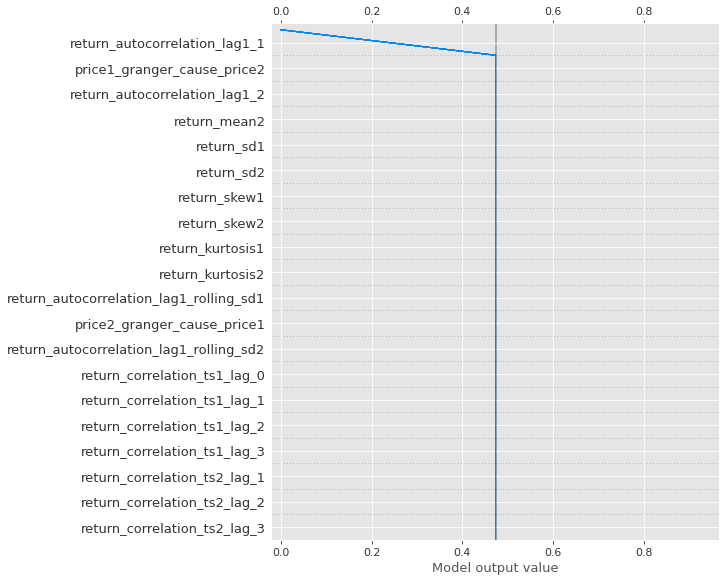

In [24]:
np.random.seed(9868)
num_iter = 10
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []

for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=9868, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    real_statistics = create_statistics(
        label="real", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20191231/sp500_20190101_20191231_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20191231/sp500_20190101_20191231_pair_prices.csv")

    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:(dataset.shape[1]-1)]
    y = dataset.iloc[:, (dataset.shape[1]-1)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
print(results)
print(accuracy_average)
print(accuracy_std)